# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook
- https://www.tensorflow.org/guide/core/logistic_regression_core
- https://www.kaggle.com/code/muelsamu/simple-tabpfn-approach-for-score-of-15-in-1-min/notebook - good example how to add TabPFN
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric - good guide on creating custom metric in Keras
- https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/410139 - overall notes about similar competitions

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [x] Make Artefacts -> Made Utility script for WoE
- [x] Solve Error With Solution -> Made If new catgory then choose worst WoEs (Can make two splits woth worst and other value )
- [x] Add TabPFN (Added Private Sample with package files) and No CV TabPFN preds
- [x] Added Weighted Submition with respect to Competion Metric Mean
- [x] Refactor More Accurately train RF part & Make Dev branch for Git
- [x] Experiment with GadientClassifier and Parameters ( Tried GadientClassifier / Added Better displayed TOC )
- [x] CV TabPFN - looks even inferior to GBT. May be due to preprosessing.
- [x] Ensembled into Submition results from several Classifiers (There is aa room for Playing with manually assigned weights)
- [x] Due to time consideration -> SUBMITION: bool
- [x] Submition Error When calculating results.
- [x] Rethink CV (check dimension) v31->v32,
- [x] Solve problem with accuracy (showns NaNs) -> Changed to Binary Accuracy version
- [x] Solved problem with NaNs in metric -> min/max vals less than 1 more than 0, as in competrion calculator
- [ ] loss: 0.0000e+00. Why ? Is it OK ? -> Yes it is okey. https://discuss.tensorflow.org/t/tfdf-custom-loss/2223
- [ ] Research wheather it is possible to train with respect to Gradient of the metric.
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )
- [ ] Ensemble Results by some model:
    - Currently Simple Manual Weights, which may be more optimal. Need to make some grid and choose the best.
    - I use Mean for Each CV Branch, may-be also grant some threshs or weights
    - [x] Refactored each Model Estimation to result into Train/Valid/Test Frames

In [1]:
SUBMITION = False

## Install TabPFN offline

In [2]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr

!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff

!cp /kaggle/input/pip-packages-icr/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr
Processing /kaggle/input/pip-packages-icr/tabpfn-0.1.9-py3-none-any.whl


# Import Utils

In [3]:
from woe_utils import WOENumericalComplex

# Import Standard Libs

In [4]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from keras import metrics # accuracy
from keras import backend as K

import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

from tabpfn import TabPFNClassifier

import warnings
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load the Dataset

In [5]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
dataset_df.columns = dataset_df.columns.str.rstrip()
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
dataset_test_df.columns = dataset_test_df.columns.str.rstrip()
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


# Compute Basic Info

In [6]:
def compute_basic_stats(columns, df):
    out = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

basic_stats_1 = compute_basic_stats(
    columns=[i for i in dataset_df.columns if i not in ["Id","Class"]],         
    df=dataset_df)

  0%|          | 0/56 [00:00<?, ?it/s]

* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


# Create Features

In [7]:
def preprocess(train: pd.DataFrame, test: pd.DataFrame, stats: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, dict):
    info = dict()
    woes = dict()
    numeric_features = stats[stats.logloss.notna()].index.tolist() # Cause for EJ logloss is null
    train_out = train.copy()
    test_out = test.copy()
    
    out_features = list()
    
    # Make WoE Columns
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        tmp_woe = WOENumericalComplex()
        tmp_woe.fit(x=train_out[i], y=train_out['Class'])
        train_out[i + '_WoE'] = tmp_woe.transform(X=train_out[i])
        test_out[i + '_WoE'] = tmp_woe.transform(X=test_out[i])
        out_features.append(i + '_WoE')
        woes[i] = tmp_woe
    
    
    # Make NA columns
    for i in tqdm(['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ'], 'Split by NA: '):
        train_out[i+'_na'] = np.where(train_out[i].isna(),1,0)
        test_out[i+'_na'] = np.where(test_out[i].isna(),1,0)
        out_features.append(i + '_na')
    
    # Basic Logic -> normalise
    for i in tqdm(numeric_features,'Normalise Numeric: '):
        if stats.loc[i,'correlation'] > 0:
            na_value = stats.loc[i,'max']
        else:
            na_value = stats.loc[i,'min']

        train_out[i] = train_out[i].fillna(na_value)
        test_out[i] = test_out[i].fillna(na_value)

        train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
        test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']

        out_features.append(i)
            
            
    # Addition EJ -> has only two values, so if EJ == 'A'
    train_out['EJ' + '_A'] = np.where(train_out['EJ'] == 'A',1,0)
    test_out['EJ' + '_A'] = np.where(test_out['EJ'] == 'A',1,0)
    out_features.append('EJ' + '_A')
    
    return train_out,test_out,out_features, woes


train_out,test_out,features, woes = preprocess(train=dataset_df, test=dataset_test_df, stats=basic_stats_1)

WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Split by NA:   0%|          | 0/9 [00:00<?, ?it/s]

Normalise Numeric:   0%|          | 0/55 [00:00<?, ?it/s]

In [8]:
train_out

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,DU_na,FC_na,FS_na,CC_na,FL_na,GL_na,CB_na,EL_na,BQ_na,EJ_A
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,-0.571689,-0.170837,-0.261457,-0.237696,-0.189141,-1.899018,-0.083350,-0.173361,-0.038323,-0.405054,...,0,0,0,0,0,0,0,0,0,0
007255e47698,-0.708530,-1.096911,-0.261457,-0.028678,-0.189141,-0.749849,-0.083350,0.678369,-0.104702,0.048502,...,0,0,0,0,0,0,0,0,0,1
013f2bd269f5,-0.015200,-0.376863,-0.261457,-0.094768,-0.189141,0.465284,-0.083350,0.519032,-0.104702,-0.071031,...,0,0,0,0,0,0,0,0,0,0
043ac50845d5,-0.480461,0.138084,0.012337,0.547033,-0.189141,-0.729018,-0.083350,0.111997,-0.104702,-0.390792,...,0,0,0,0,0,0,0,0,0,0
044fb8a146ec,-0.206778,0.100436,-0.261457,-0.356596,-0.189141,-0.628336,-0.013218,-1.647955,1.443968,0.125225,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,-0.699408,-0.161696,0.040200,-0.422420,0.274992,-0.801926,0.040841,-0.464514,-0.080545,-0.394762,...,0,0,0,0,0,0,0,0,0,1
fd895603f071,-0.088182,0.852064,-0.261457,0.108743,0.555666,0.170181,-0.082619,0.472679,-0.065608,0.100514,...,0,0,0,0,0,0,0,0,0,0
fd8ef6377f76,-0.106427,-0.453374,0.090067,0.235016,-0.011664,0.989527,-0.083350,1.112925,-0.104702,0.178229,...,0,0,0,0,0,0,0,0,0,1


In [9]:
basic_stats_2 = compute_basic_stats(
    columns=[i for i in train_out.columns if i not in ["Id","Class"]],         
    df=train_out)

basic_stats_2

  0%|          | 0/121 [00:00<?, ?it/s]

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU_WoE,4,0.0,float64,-0.52,-2.678782,2.977892,1.042059,0.286027,4.790242
FL_WoE,4,0.0,float64,-0.42,-2.045013,2.977892,0.86161,0.214552,5.374418
DI_WoE,3,0.0,float64,-0.37,-2.361247,0.382521,0.698812,0.124925,5.432836
DA_WoE,3,0.0,float64,-0.37,-2.093932,0.463416,0.719046,0.14452,5.549671
GL_WoE,4,0.0,float64,-0.4,-1.805209,2.977892,0.865805,0.230269,5.783341
FD_WoE,3,0.0,float64,-0.33,-1.996604,0.379845,0.635814,0.115675,5.783341
EH_WoE,3,0.0,float64,-0.32,-2.061142,0.343225,0.622624,0.111704,5.841759
EH,127,0.0,float64,0.18,-0.1635,22.876681,1.0,-0.0,5.900177
AM,605,0.0,float64,0.24,-0.513293,8.483647,1.0,0.0,5.900177
BC_WoE,3,0.0,float64,-0.3,-1.9811,0.486565,0.630381,0.116679,5.900177


# Train Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [10]:

class BalancedLogLoss(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_log_loss', **kwargs):
        super(BalancedLogLoss, self).__init__(name=name, **kwargs)
        self.log_loss = self.add_weight(name='log_loss', initializer='zeros')

    def update_state(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None):
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Correct Values
        min_val = 1e-15
        max_val = 0.999999999999999
        
        y_pred = tf.math.minimum(y_pred, [max_val])
        y_pred = tf.math.maximum(y_pred, [min_val])
        
        log_y_pred_1 = tf.reshape(K.log(y_pred),[-1,1])
        log_y_pred_0 = tf.reshape(K.log(1-y_pred),[-1,1])

        y_1 = tf.reshape(y_true,[1,-1])
        y_0 = 1-y_1

        logloss_1 = -K.dot(y_1,log_y_pred_1)[0][0]/K.sum(y_1)
        logloss_0 = -K.dot(y_0,log_y_pred_0)[0][0]/K.sum(y_0)

        av_logloss = (logloss_1+logloss_0)/2
        
        self.log_loss.assign_add(av_logloss)

    def result(self):
        return self.log_loss

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.log_loss.assign(0.)

def plot_train_logs(model) -> None:

    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()

def train_model(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6,
                model_obj = tfdf.keras.RandomForestModel,
                model_kwargs = dict(),
                model_compile_kwargs = dict()) -> (pd.DataFrame, pd.DataFrame, dict,  dict):

    # Create a various frames
    train_summary = pd.DataFrame(data=np.full((len(train.index),n_splits), np.nan), index=train.index) # For In-Sample Predictions of each Fold
    
    valid_summary = pd.DataFrame(data=np.full((len(train.index),1), np.nan), index=train.index) # For Out-of-Sample Prediction of each Fold
    
    test_tf = tfdf.keras.pd_dataframe_to_tf_dataset(test) # Technial, to conert frame to tensor for makind a predictions using tensor framework
    test_summary = pd.DataFrame(data=np.full((len(test.index),n_splits), np.nan),index=test.index) # For Test (Sumbition) Predictions of each Fold's Model
    
    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Calculate the number of samples for each label.
    neg, pos = np.bincount(train[label])
    total = neg + pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            valid_ids = valid_df.index.values
            train_ids = train_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # We need to convert the datatset from Pandas format (pd.DataFrame)
            train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
            valid_tf = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

            # Define & Train the model and metrics
            model = model_obj(**model_kwargs)
            model.compile(**model_compile_kwargs) 
            model.fit(x=train_tf, class_weight=class_weight)

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict Values
            train_summary.loc[train_ids, i] = model.predict(x=train_tf).flatten()
            valid_summary.loc[valid_ids, 0] = model.predict(x=valid_tf).flatten()
            test_summary[i] = model.predict(x=test_tf).flatten() 

            # Evaluate and store the metrics in respective dicts
            evaluation = model.evaluate(x=train_tf,return_dict=True)
            train_metric = evaluation["balanced_log_loss"]
            
            evaluation = model.evaluate(x=valid_tf,return_dict=True)
            val_metric = evaluation["balanced_log_loss"]
            
            # Plot Results
            plot_train_logs(model)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
         
    return train_summary, valid_summary, test_summary, models, metrics

# RandomForestModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpjnwn4jkp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:09.590900. Found 514 examples.
Training model...
Model trained in 0:00:00.785683
Compiling model...


[INFO 23-07-22 07:59:57.3200 UTC kernel.cc:1242] Loading model from path /tmp/tmpjnwn4jkp/model/ with prefix f7b7d3e5bb984be0
[INFO 23-07-22 07:59:57.4578 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 32956 node(s), and 114 input feature(s).
[INFO 23-07-22 07:59:57.4581 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 07:59:57.4582 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 0s 401ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9612 - balanced_log_loss: 0.3083


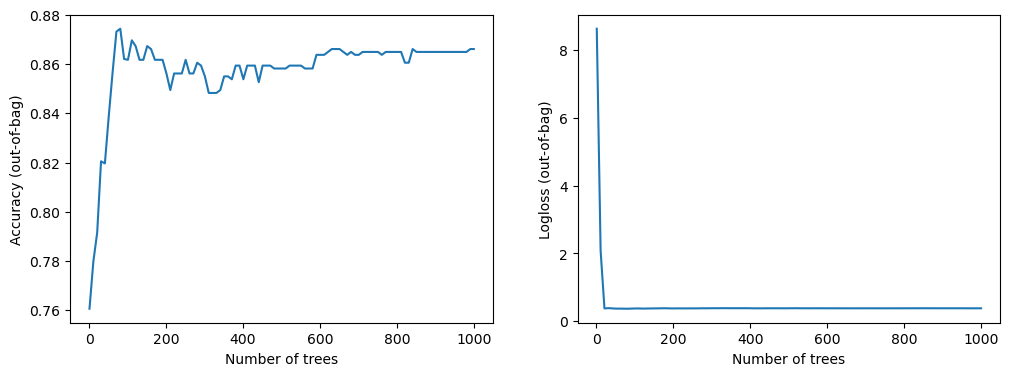


Train: 0.1878 Validation: 0.3083
##### Fold 2
Use /tmp/tmpqkqk9mmg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.193404. Found 514 examples.
Training model...
Model trained in 0:00:00.891725
Compiling model...


[INFO 23-07-22 08:00:09.0555 UTC kernel.cc:1242] Loading model from path /tmp/tmpqkqk9mmg/model/ with prefix 6a22e2526e1742bf
[INFO 23-07-22 08:00:09.2021 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 32686 node(s), and 113 input feature(s).
[INFO 23-07-22 08:00:09.2021 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:00:09.2022 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 428ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8447 - balanced_log_loss: 0.4080


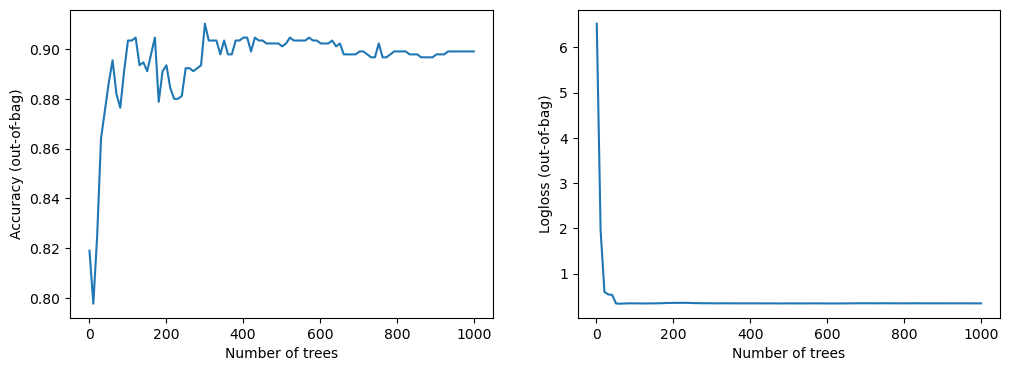


Train: 0.4765 Validation: 0.4080
##### Fold 3
Use /tmp/tmpl05b48io as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.209251. Found 514 examples.
Training model...
Model trained in 0:00:00.735288
Compiling model...


[INFO 23-07-22 08:00:16.8792 UTC kernel.cc:1242] Loading model from path /tmp/tmpl05b48io/model/ with prefix 8766354d3f064ea2
[INFO 23-07-22 08:00:17.0191 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33890 node(s), and 113 input feature(s).
[INFO 23-07-22 08:00:17.0194 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 394ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.3164


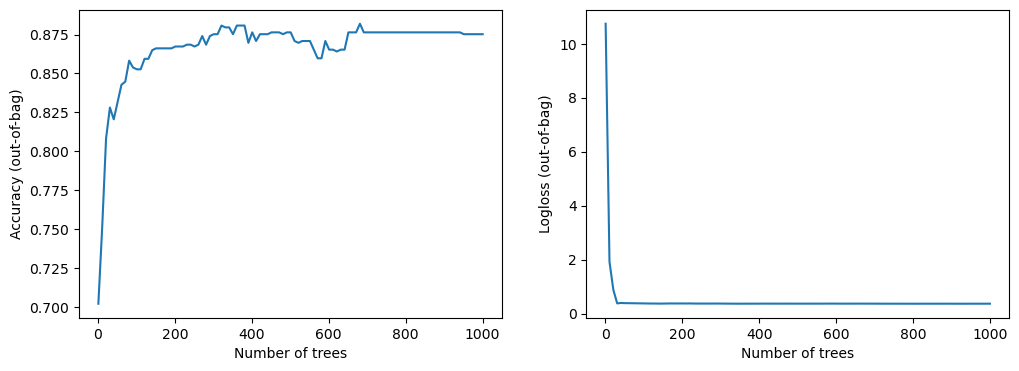


Train: 0.5861 Validation: 0.3164
##### Fold 4
Use /tmp/tmpfv09sy6_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.246434. Found 514 examples.
Training model...
Model trained in 0:00:00.714854
Compiling model...


[INFO 23-07-22 08:00:25.0740 UTC kernel.cc:1242] Loading model from path /tmp/tmpfv09sy6_/model/ with prefix db51fe3bb6cf4f1d
[INFO 23-07-22 08:00:25.2102 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33338 node(s), and 112 input feature(s).
[INFO 23-07-22 08:00:25.2103 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:00:25.2103 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 378ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9223 - balanced_log_loss: 0.3642


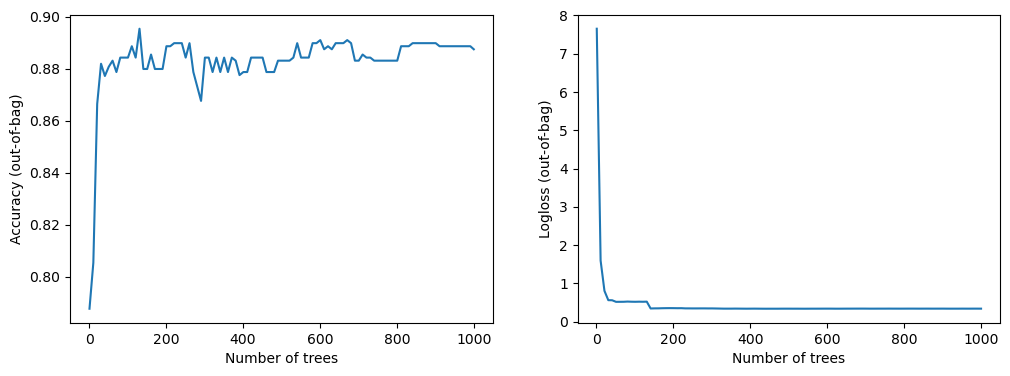


Train: 0.4843 Validation: 0.3642
##### Fold 5
Use /tmp/tmpp7l1wd6p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.181047. Found 514 examples.
Training model...
Model trained in 0:00:00.742406
Compiling model...


[INFO 23-07-22 08:00:32.8018 UTC kernel.cc:1242] Loading model from path /tmp/tmpp7l1wd6p/model/ with prefix ed3627700b114b23
[INFO 23-07-22 08:00:32.9411 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 32930 node(s), and 113 input feature(s).
[INFO 23-07-22 08:00:32.9412 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 403ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.4281


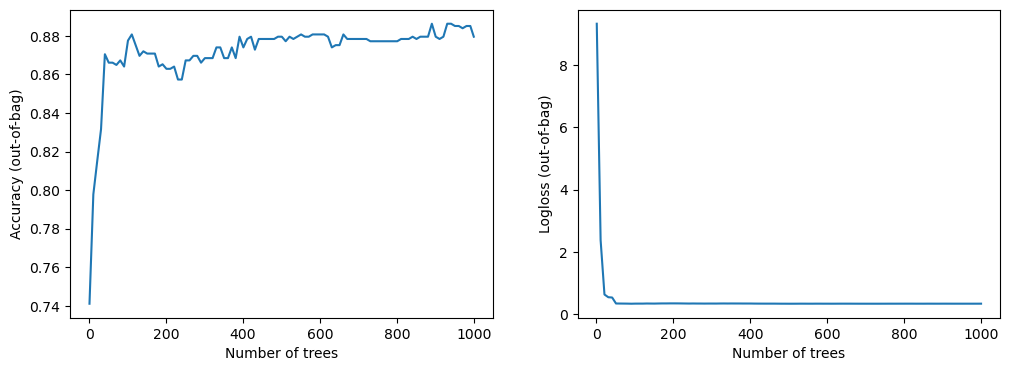


Train: 0.5298 Validation: 0.4281
##### Fold 6
Use /tmp/tmpcwten07f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.191851. Found 515 examples.
Training model...
Model trained in 0:00:00.885978
Compiling model...


[INFO 23-07-22 08:00:40.8148 UTC kernel.cc:1242] Loading model from path /tmp/tmpcwten07f/model/ with prefix 34b7a70fb0e74381
[INFO 23-07-22 08:00:40.9522 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33646 node(s), and 113 input feature(s).
[INFO 23-07-22 08:00:40.9522 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:00:40.9523 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 398ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9706 - balanced_log_loss: 0.2618


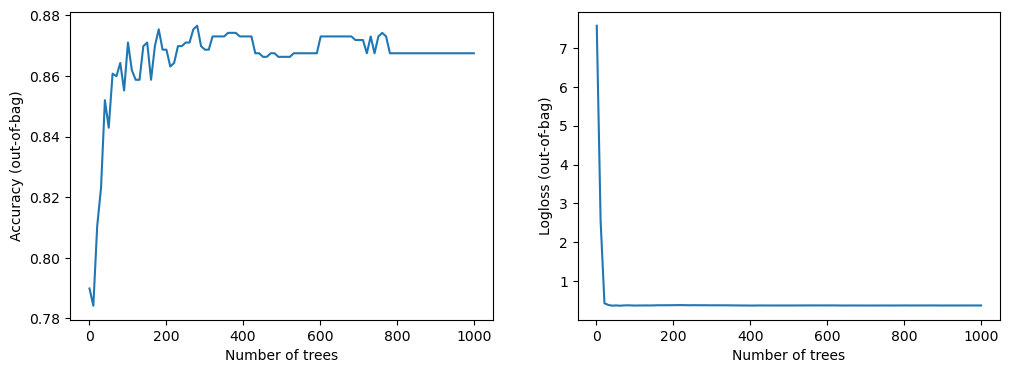


Train: 0.6131 Validation: 0.2618

Train mean: 0.4796 std: 0.1529

Validation mean: 0.3478 std: 0.0637


In [11]:
# RandomForestModel
if not SUBMITION:
    train_summary_rf_1, valid_summary_rf_1, test_summary_rf_1, model_rf_1,metrics_rf_1 = train_model(
        train=train_out,test=test_out, features=features,
        n_splits=6,
        model_obj=tfdf.keras.RandomForestModel,
        model_kwargs=dict(max_depth=6, num_trees=1000),
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpyrqmnq5k as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.208892. Found 555 examples.
Training model...
Model trained in 0:00:00.244215
Compiling model...


[INFO 23-07-22 08:00:48.3097 UTC kernel.cc:1242] Loading model from path /tmp/tmpyrqmnq5k/model/ with prefix 001561d5750945c8
[INFO 23-07-22 08:00:48.3519 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10190 node(s), and 112 input feature(s).
[INFO 23-07-22 08:00:48.3520 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 408ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.3015


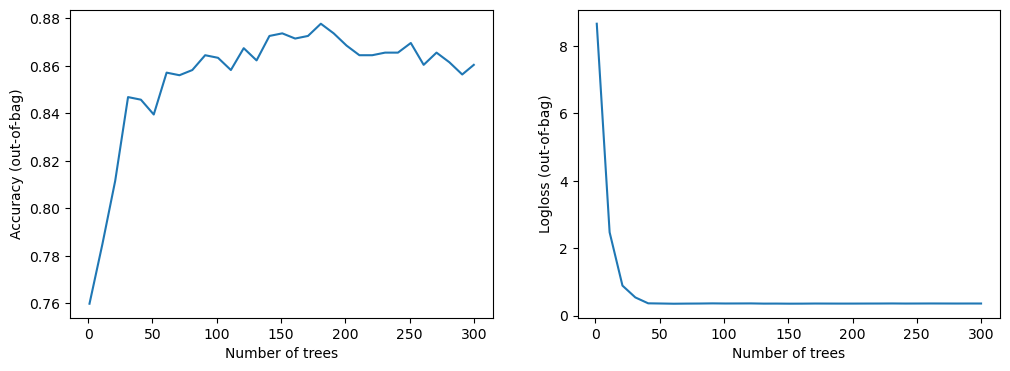


Train: 0.1855 Validation: 0.3015
##### Fold 2
Use /tmp/tmpy6ayd3qi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.193796. Found 555 examples.
Training model...
Model trained in 0:00:00.244518
Compiling model...


[INFO 23-07-22 08:00:56.0099 UTC kernel.cc:1242] Loading model from path /tmp/tmpy6ayd3qi/model/ with prefix 68df1a3a1c1d4646
[INFO 23-07-22 08:00:56.0518 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10330 node(s), and 113 input feature(s).
[INFO 23-07-22 08:00:56.0518 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:00:56.0519 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 383ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.3116


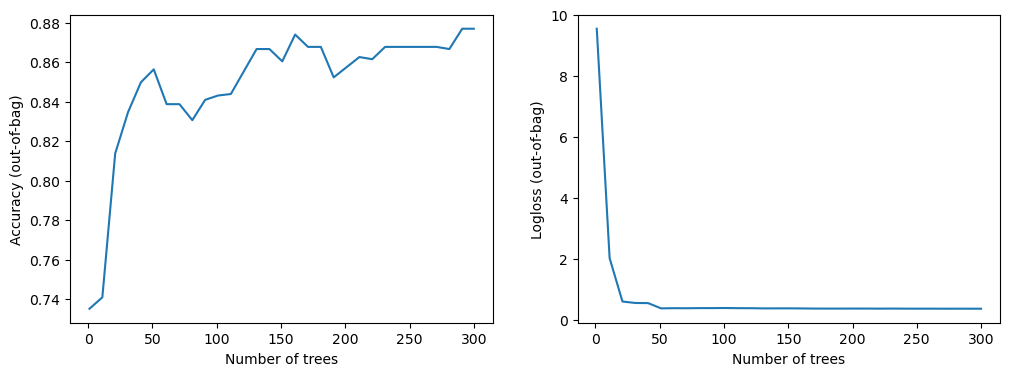


Train: 0.4840 Validation: 0.3116
##### Fold 3
Use /tmp/tmpiyijt9ca as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.252015. Found 555 examples.
Training model...
Model trained in 0:00:00.243215
Compiling model...


[INFO 23-07-22 08:01:04.2961 UTC kernel.cc:1242] Loading model from path /tmp/tmpiyijt9ca/model/ with prefix e4c31799129c481a
[INFO 23-07-22 08:01:04.3375 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10300 node(s), and 112 input feature(s).
[INFO 23-07-22 08:01:04.3376 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 368ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8548 - balanced_log_loss: 0.4417


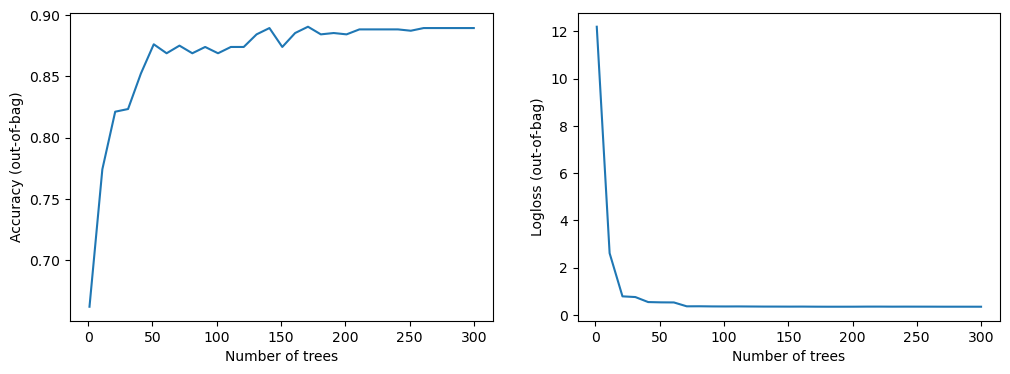


Train: 0.4848 Validation: 0.4417
##### Fold 4
Use /tmp/tmp8oysv9_g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.248664. Found 555 examples.
Training model...
Model trained in 0:00:00.247782
Compiling model...


[INFO 23-07-22 08:01:12.5803 UTC kernel.cc:1242] Loading model from path /tmp/tmp8oysv9_g/model/ with prefix f310d2b97fff445b
[INFO 23-07-22 08:01:12.6219 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10264 node(s), and 111 input feature(s).
[INFO 23-07-22 08:01:12.6220 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:01:12.6221 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 385ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8710 - balanced_log_loss: 0.3305


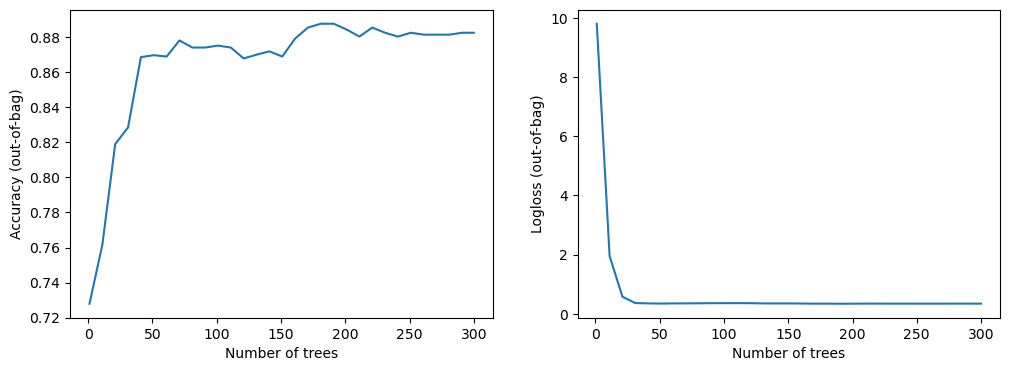


Train: 0.6168 Validation: 0.3305
##### Fold 5
Use /tmp/tmpodh8tmr0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.170960. Found 555 examples.
Training model...
Model trained in 0:00:00.247369
Compiling model...


[INFO 23-07-22 08:01:19.7238 UTC kernel.cc:1242] Loading model from path /tmp/tmpodh8tmr0/model/ with prefix 1421a4699de64d44
[INFO 23-07-22 08:01:19.7664 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10450 node(s), and 112 input feature(s).
[INFO 23-07-22 08:01:19.7664 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 391ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.3279


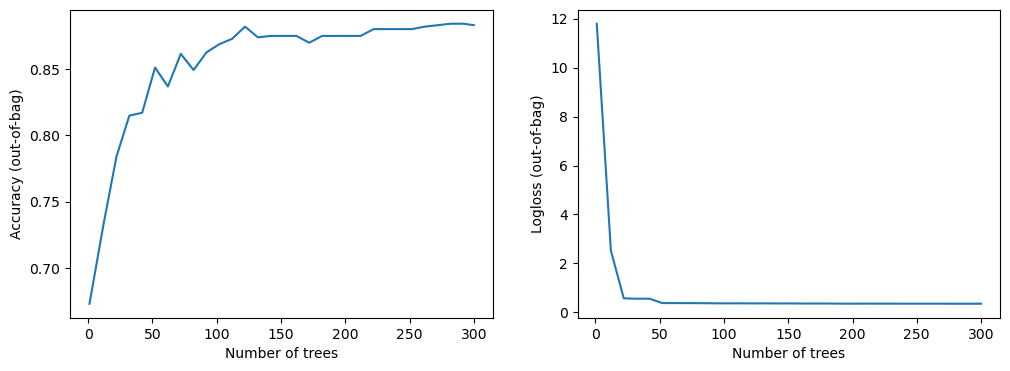


Train: 0.5066 Validation: 0.3279
##### Fold 6
Use /tmp/tmp016tqpnh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.209479. Found 555 examples.
Training model...
Model trained in 0:00:00.248310
Compiling model...


[INFO 23-07-22 08:01:26.8822 UTC kernel.cc:1242] Loading model from path /tmp/tmp016tqpnh/model/ with prefix a7b22cb6784240a8
[INFO 23-07-22 08:01:26.9238 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10332 node(s), and 112 input feature(s).
[INFO 23-07-22 08:01:26.9238 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:01:26.9238 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 386ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3564


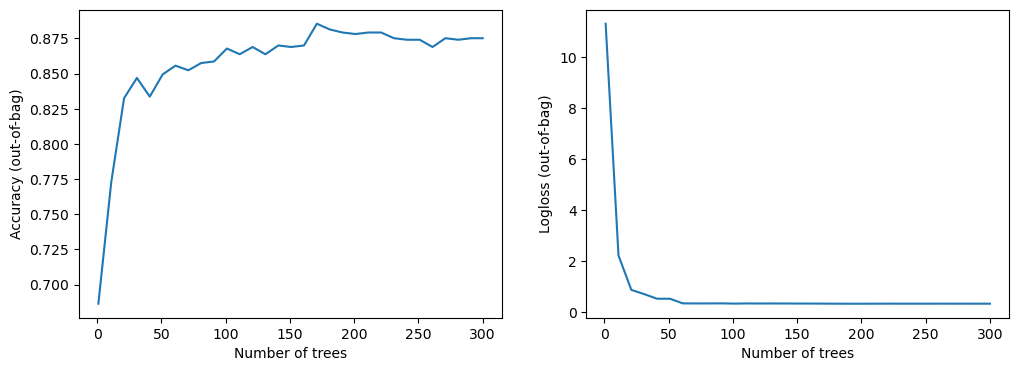


Train: 0.5020 Validation: 0.3564
##### Fold 7
Use /tmp/tmpgptb2xe3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.183672. Found 555 examples.
Training model...
Model trained in 0:00:00.240551
Compiling model...


[INFO 23-07-22 08:01:34.5005 UTC kernel.cc:1242] Loading model from path /tmp/tmpgptb2xe3/model/ with prefix c101c2ca73e44293
[INFO 23-07-22 08:01:34.5423 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10312 node(s), and 112 input feature(s).
[INFO 23-07-22 08:01:34.5423 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 375ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.4016


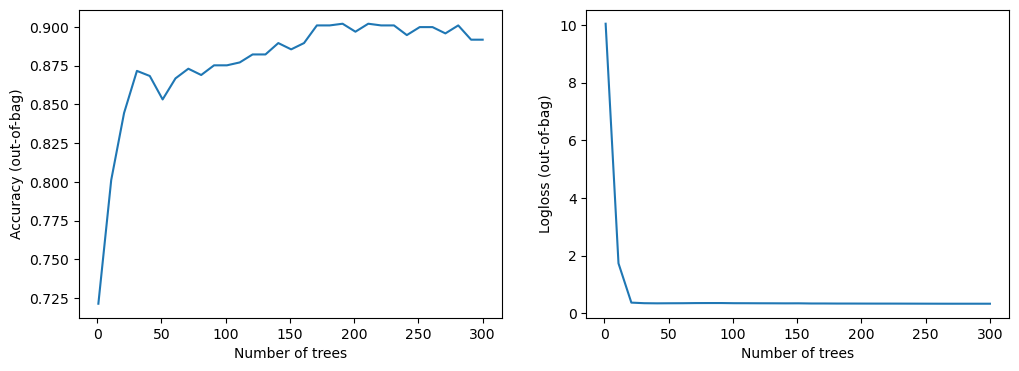


Train: 0.5269 Validation: 0.4016
##### Fold 8
Use /tmp/tmpj_2lgl6d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.162540. Found 556 examples.
Training model...
Model trained in 0:00:00.245880
Compiling model...


[INFO 23-07-22 08:01:41.5719 UTC kernel.cc:1242] Loading model from path /tmp/tmpj_2lgl6d/model/ with prefix baf56f52316e4e1f
[INFO 23-07-22 08:01:41.6138 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10334 node(s), and 112 input feature(s).
[INFO 23-07-22 08:01:41.6138 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:01:41.6139 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 385ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_log_loss: 0.3344


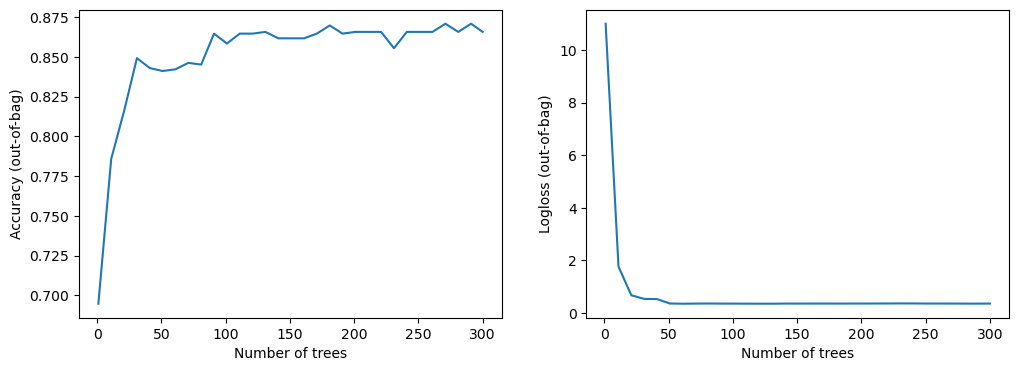


Train: 0.5754 Validation: 0.3344
##### Fold 9
Use /tmp/tmp5e354zvt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.221273. Found 556 examples.
Training model...
Model trained in 0:00:00.250005
Compiling model...


[INFO 23-07-22 08:01:48.8284 UTC kernel.cc:1242] Loading model from path /tmp/tmp5e354zvt/model/ with prefix f7f4ab9757844597
[INFO 23-07-22 08:01:48.8715 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10174 node(s), and 112 input feature(s).
[INFO 23-07-22 08:01:48.8716 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 405ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_log_loss: 0.4160


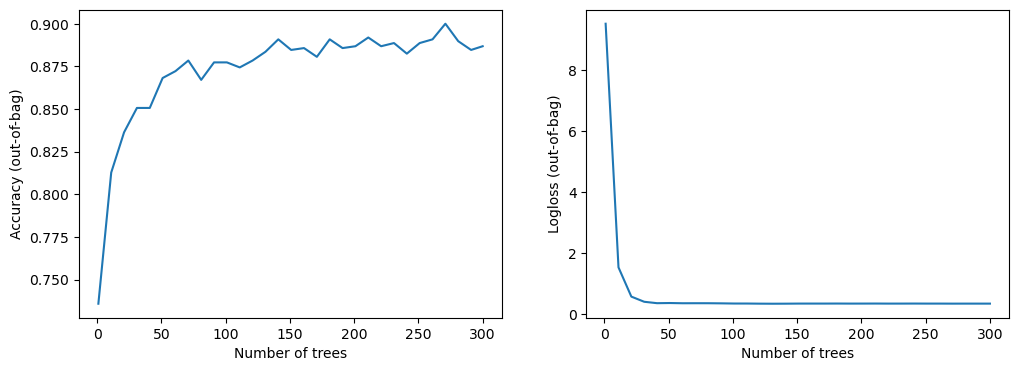


Train: 0.5072 Validation: 0.4160
##### Fold 10
Use /tmp/tmpzcm7la2c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.172292. Found 556 examples.
Training model...
Model trained in 0:00:00.247721
Compiling model...


[INFO 23-07-22 08:01:56.0360 UTC kernel.cc:1242] Loading model from path /tmp/tmpzcm7la2c/model/ with prefix 4dbf0730baca49b0
[INFO 23-07-22 08:01:56.0783 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10428 node(s), and 112 input feature(s).
[INFO 23-07-22 08:01:56.0784 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:01:56.0784 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 381ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.2804


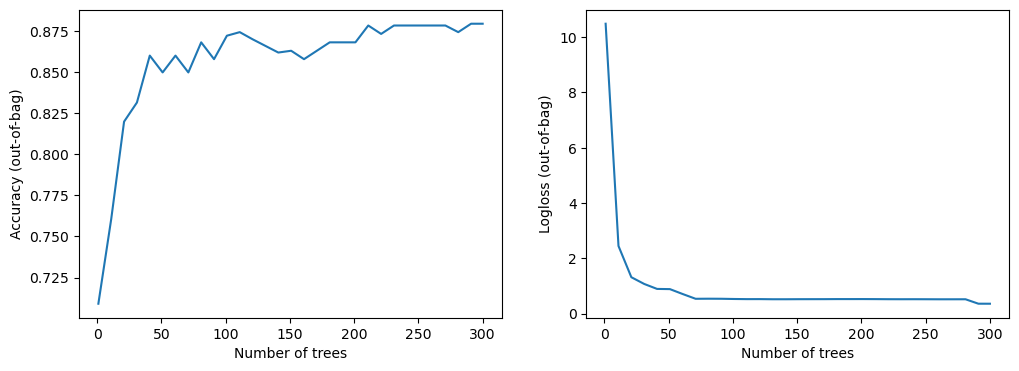


Train: 0.5957 Validation: 0.2804

Train mean: 0.4985 std: 0.1196

Validation mean: 0.3502 std: 0.0530


In [12]:
# RandomForestModel
if not SUBMITION:
    train_summary_rf_2, valid_summary_rf_2, test_summary_rf_2, model_rf_2,metrics_rf_2 = train_model(
        train=train_out,test=test_out, features=features,                                             
        n_splits=10,                    
        model_obj=tfdf.keras.RandomForestModel,           
        model_kwargs=dict(max_depth=6, num_trees=300),                                                  
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpm5ybkpuw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.248039. Found 555 examples.
Training model...
Model trained in 0:00:00.190439
Compiling model...


[INFO 23-07-22 08:02:02.1208 UTC kernel.cc:1242] Loading model from path /tmp/tmpm5ybkpuw/model/ with prefix 3e024ff5f9304ea5
[INFO 23-07-22 08:02:02.1665 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11186 node(s), and 58 input feature(s).
[INFO 23-07-22 08:02:02.1665 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 274ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2470


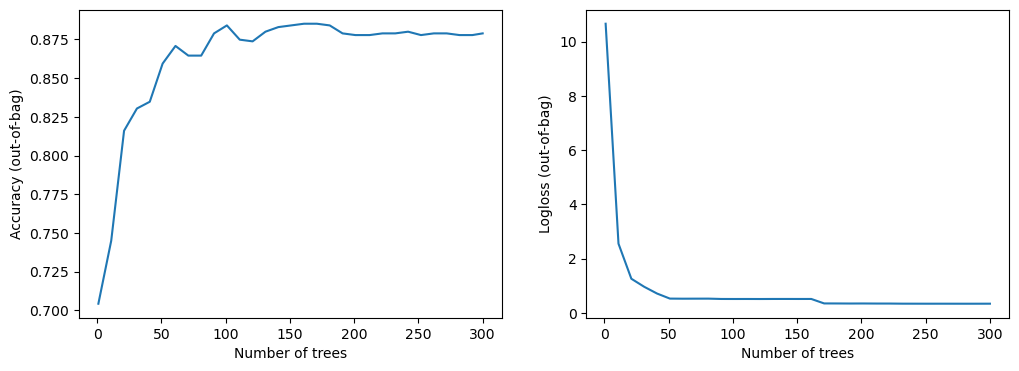


Train: 0.2012 Validation: 0.2470
##### Fold 2
Use /tmp/tmpa7eh8put as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.300761. Found 555 examples.
Training model...
Model trained in 0:00:00.197546
Compiling model...


[INFO 23-07-22 08:02:06.8755 UTC kernel.cc:1242] Loading model from path /tmp/tmpa7eh8put/model/ with prefix b81e72ed3e444919
[INFO 23-07-22 08:02:06.9198 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-22 08:02:06.9198 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:02:06.9198 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 272ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2757


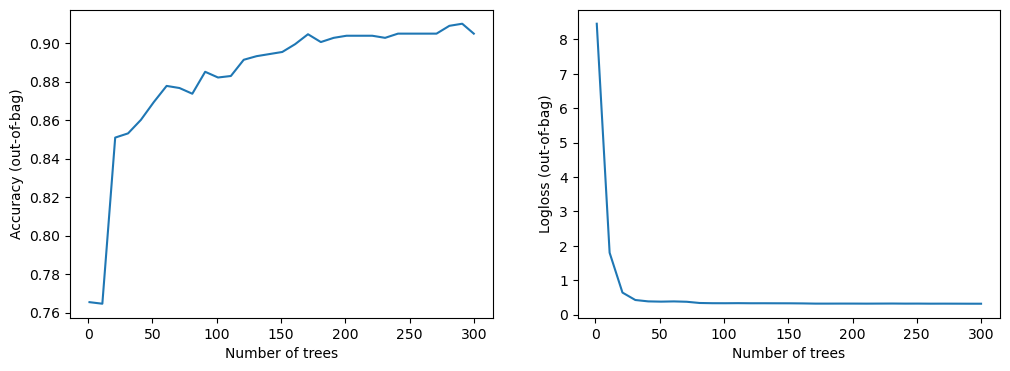


Train: 0.4433 Validation: 0.2757
##### Fold 3
Use /tmp/tmprg5m43q3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.291431. Found 555 examples.
Training model...
Model trained in 0:00:00.190978
Compiling model...


[INFO 23-07-22 08:02:12.1452 UTC kernel.cc:1242] Loading model from path /tmp/tmprg5m43q3/model/ with prefix 1a5bb4cd03814da6
[INFO 23-07-22 08:02:12.1892 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11012 node(s), and 58 input feature(s).
[INFO 23-07-22 08:02:12.1896 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 269ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3758


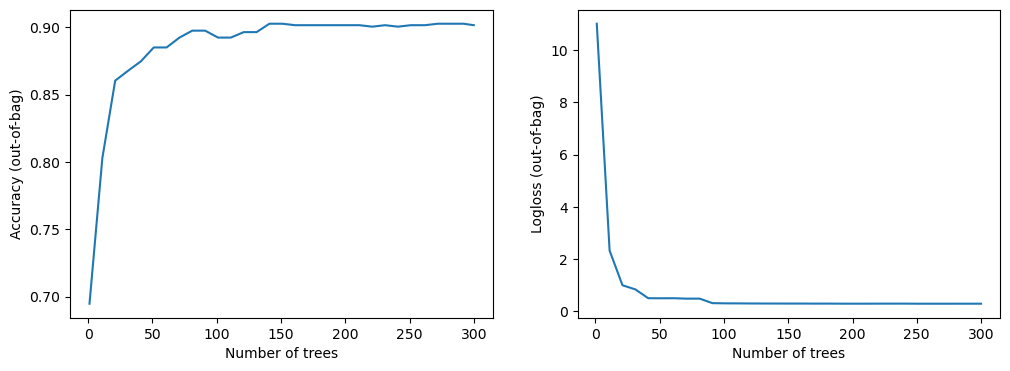


Train: 0.4615 Validation: 0.3758
##### Fold 4
Use /tmp/tmpx9md5kg1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.250475. Found 555 examples.
Training model...
Model trained in 0:00:00.193671
Compiling model...


[INFO 23-07-22 08:02:16.7567 UTC kernel.cc:1242] Loading model from path /tmp/tmpx9md5kg1/model/ with prefix 0508849d4a2c4dfb
[INFO 23-07-22 08:02:16.8020 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-22 08:02:16.8021 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 274ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.3001


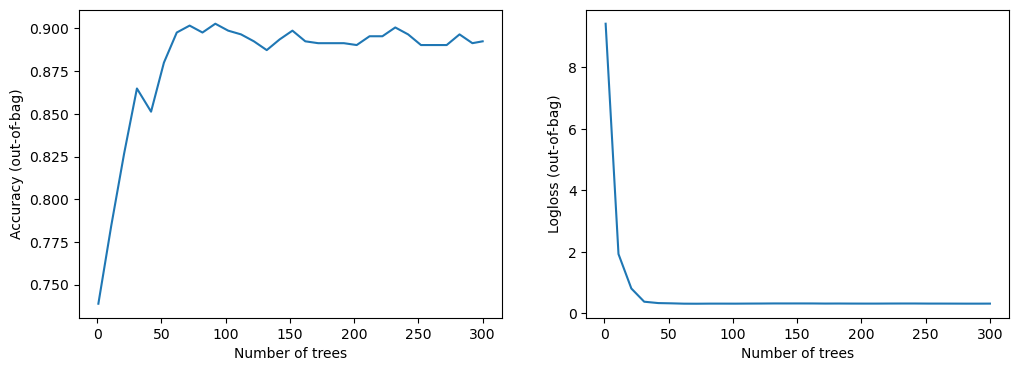


Train: 0.5660 Validation: 0.3001
##### Fold 5
Use /tmp/tmpx3uo8yoh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.289503. Found 555 examples.
Training model...
Model trained in 0:00:00.196199
Compiling model...


[INFO 23-07-22 08:02:21.4054 UTC kernel.cc:1242] Loading model from path /tmp/tmpx3uo8yoh/model/ with prefix bd31ed53ae2b4f96
[INFO 23-07-22 08:02:21.4519 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11294 node(s), and 58 input feature(s).
[INFO 23-07-22 08:02:21.4519 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:02:21.4519 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 270ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2855


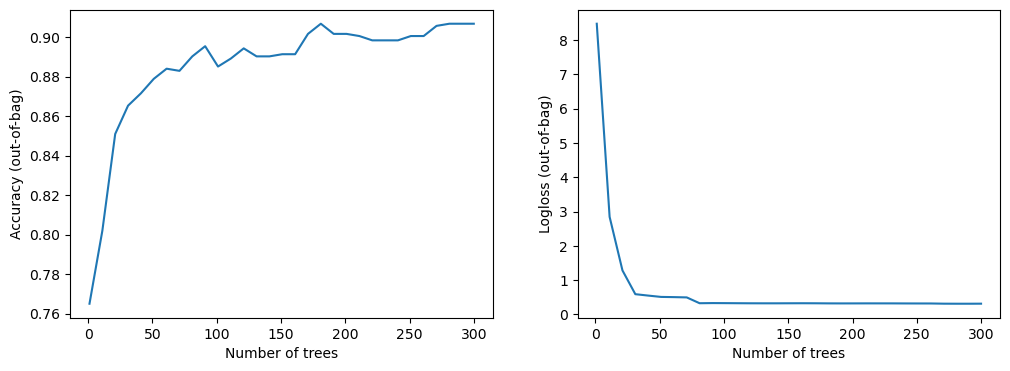


Train: 0.4859 Validation: 0.2855
##### Fold 6
Use /tmp/tmp5sll_yb0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.268361. Found 555 examples.
Training model...
Model trained in 0:00:00.191803
Compiling model...


[INFO 23-07-22 08:02:26.0503 UTC kernel.cc:1242] Loading model from path /tmp/tmp5sll_yb0/model/ with prefix 6750f45270b748c0
[INFO 23-07-22 08:02:26.0947 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11238 node(s), and 58 input feature(s).
[INFO 23-07-22 08:02:26.0948 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 270ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3069


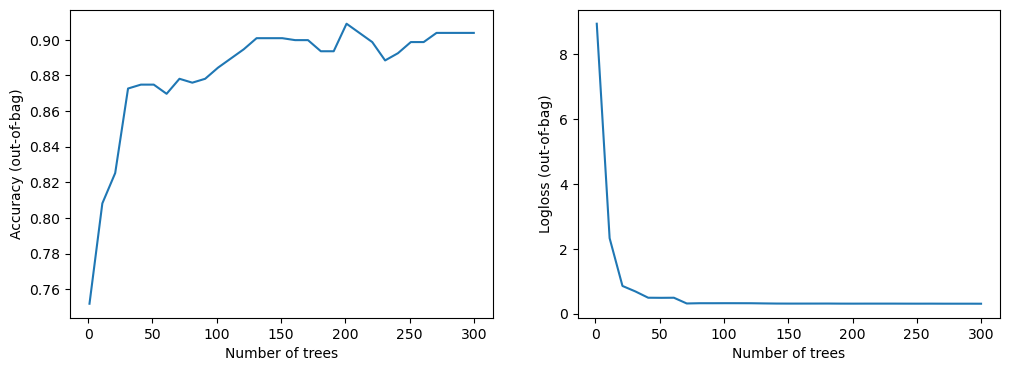


Train: 0.4704 Validation: 0.3069
##### Fold 7
Use /tmp/tmpnik0hble as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.273131. Found 555 examples.
Training model...
Model trained in 0:00:00.218367
Compiling model...


[INFO 23-07-22 08:02:30.6038 UTC kernel.cc:1242] Loading model from path /tmp/tmpnik0hble/model/ with prefix 9d177aa1168b49c3
[INFO 23-07-22 08:02:30.6493 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11262 node(s), and 59 input feature(s).
[INFO 23-07-22 08:02:30.6494 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 294ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3602


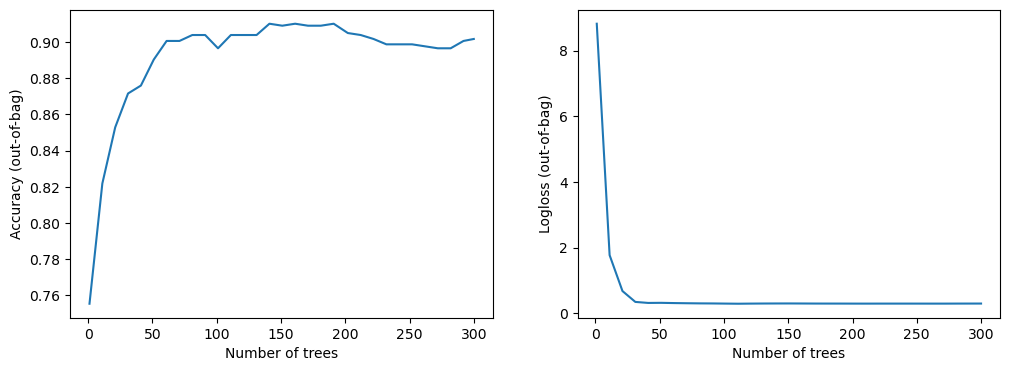


Train: 0.4883 Validation: 0.3602
##### Fold 8
Use /tmp/tmpskqd0oct as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.257000. Found 556 examples.
Training model...
Model trained in 0:00:00.189525
Compiling model...


[INFO 23-07-22 08:02:35.1286 UTC kernel.cc:1242] Loading model from path /tmp/tmpskqd0oct/model/ with prefix 6e3abca14fec49e8
[INFO 23-07-22 08:02:35.1732 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11146 node(s), and 58 input feature(s).
[INFO 23-07-22 08:02:35.1733 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:02:35.1733 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 271ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.3318


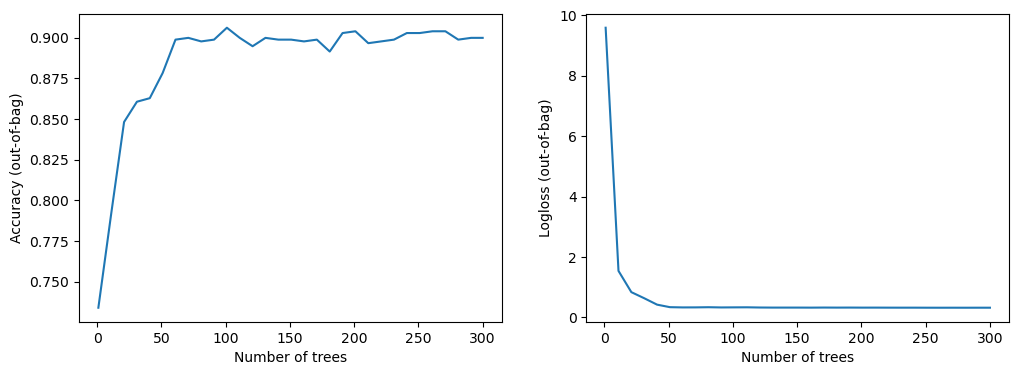


Train: 0.5488 Validation: 0.3318
##### Fold 9
Use /tmp/tmpe88ngd23 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.290138. Found 556 examples.
Training model...
Model trained in 0:00:00.189119
Compiling model...


[INFO 23-07-22 08:02:39.6613 UTC kernel.cc:1242] Loading model from path /tmp/tmpe88ngd23/model/ with prefix f54c9911f61f4261
[INFO 23-07-22 08:02:39.7059 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11126 node(s), and 58 input feature(s).
[INFO 23-07-22 08:02:39.7060 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 263ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3449


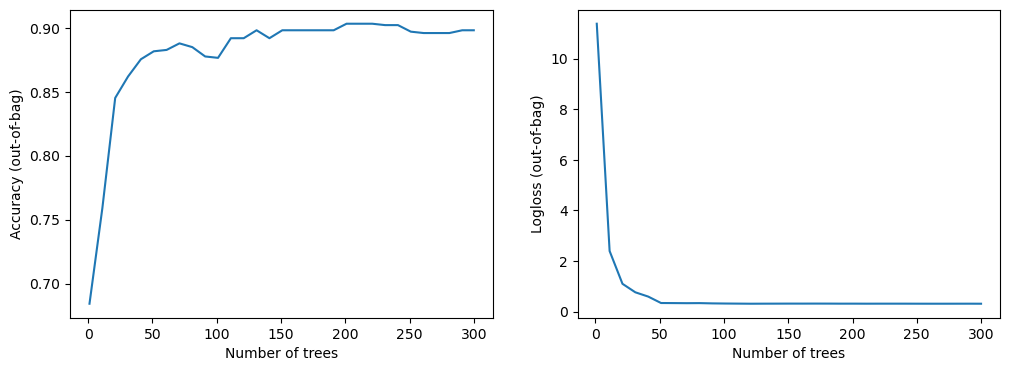


Train: 0.5168 Validation: 0.3449
##### Fold 10
Use /tmp/tmpg6lt37mv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.295021. Found 556 examples.
Training model...
Model trained in 0:00:00.192563
Compiling model...


[INFO 23-07-22 08:02:44.2024 UTC kernel.cc:1242] Loading model from path /tmp/tmpg6lt37mv/model/ with prefix bed25c7298ee458d
[INFO 23-07-22 08:02:44.2471 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11154 node(s), and 58 input feature(s).
[INFO 23-07-22 08:02:44.2472 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 265ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.2687


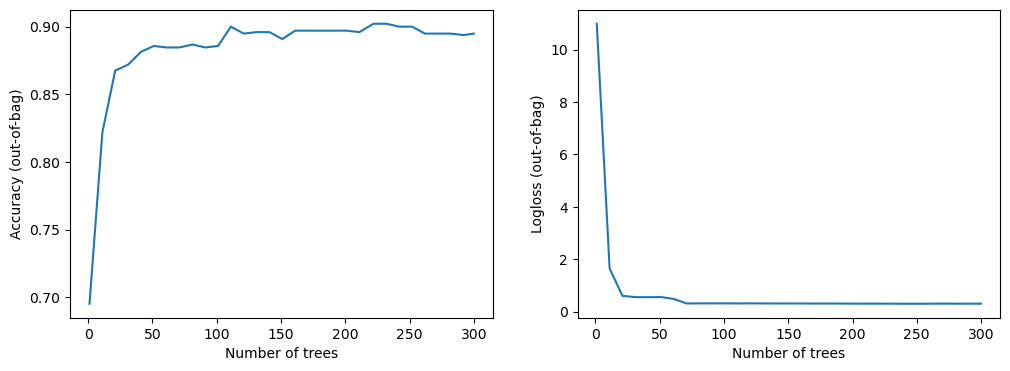


Train: 0.5330 Validation: 0.2687

Train mean: 0.4715 std: 0.1028

Validation mean: 0.3096 std: 0.0423


In [13]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=300),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpqyrameai as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.274340. Found 555 examples.
Training model...
Model trained in 0:00:00.195834
Compiling model...


[INFO 23-07-22 08:02:49.4123 UTC kernel.cc:1242] Loading model from path /tmp/tmpqyrameai/model/ with prefix 0688be6e654e4f38
[INFO 23-07-22 08:02:49.4578 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11186 node(s), and 58 input feature(s).
[INFO 23-07-22 08:02:49.4578 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:02:49.4579 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 306ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2470


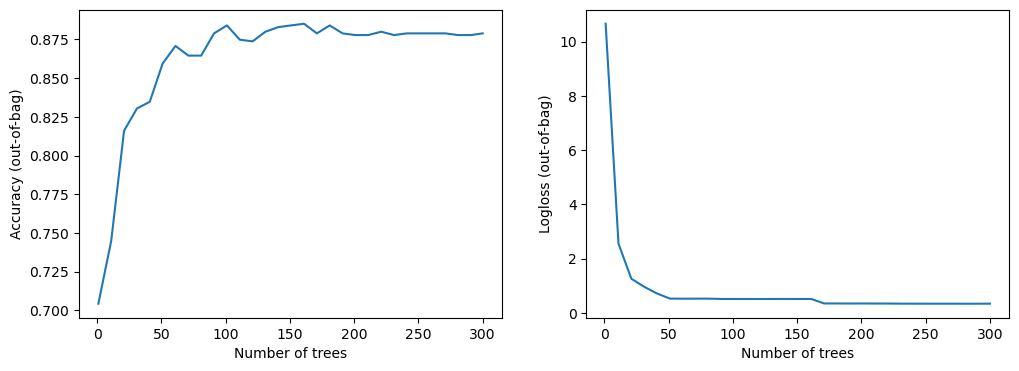


Train: 0.2012 Validation: 0.2470
##### Fold 2
Use /tmp/tmppn0f_vgs as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.260099. Found 555 examples.
Training model...
Model trained in 0:00:00.190297
Compiling model...


[INFO 23-07-22 08:02:54.7802 UTC kernel.cc:1242] Loading model from path /tmp/tmppn0f_vgs/model/ with prefix 6462bc9c0bf94b75
[INFO 23-07-22 08:02:54.8259 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-22 08:02:54.8260 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 278ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2757


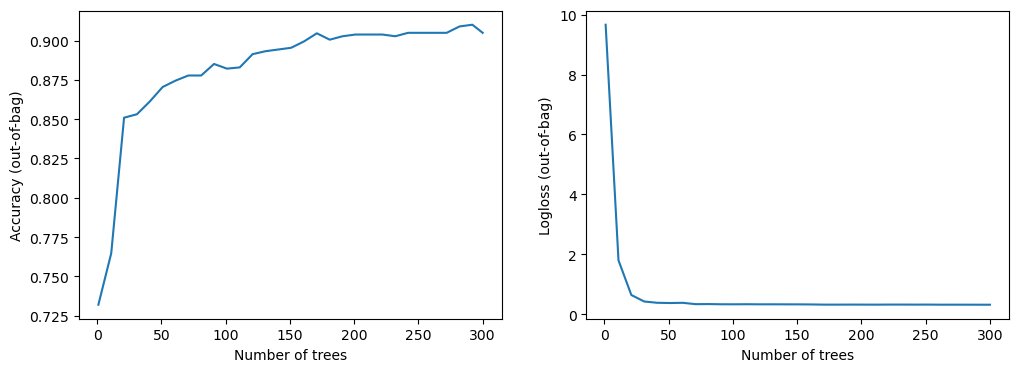


Train: 0.4433 Validation: 0.2757
##### Fold 3
Use /tmp/tmpxgjvodmu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.287774. Found 555 examples.
Training model...
Model trained in 0:00:00.195310
Compiling model...


[INFO 23-07-22 08:02:59.7396 UTC kernel.cc:1242] Loading model from path /tmp/tmpxgjvodmu/model/ with prefix bd01a1e9e31f429e
[INFO 23-07-22 08:02:59.7833 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11012 node(s), and 58 input feature(s).
[INFO 23-07-22 08:02:59.7833 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:02:59.7834 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 278ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3758


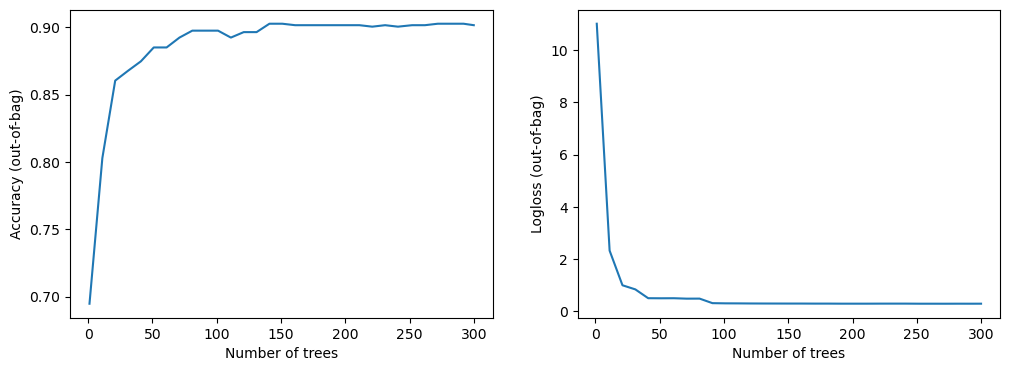


Train: 0.4615 Validation: 0.3758
##### Fold 4
Use /tmp/tmpu5alww2_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.301846. Found 555 examples.
Training model...
Model trained in 0:00:00.190298
Compiling model...


[INFO 23-07-22 08:03:04.3033 UTC kernel.cc:1242] Loading model from path /tmp/tmpu5alww2_/model/ with prefix b7cbe5dd45e44362
[INFO 23-07-22 08:03:04.3474 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-22 08:03:04.3475 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 273ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.3001


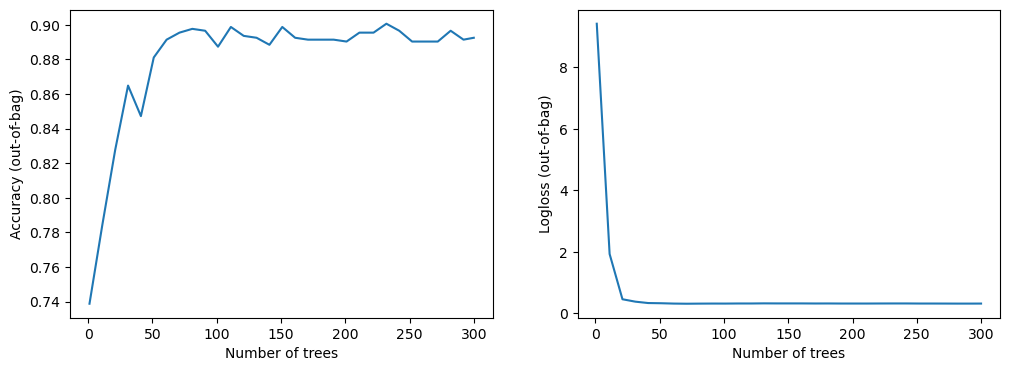


Train: 0.5660 Validation: 0.3001
##### Fold 5
Use /tmp/tmp6ux47db3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.273462. Found 555 examples.
Training model...
Model trained in 0:00:00.194149
Compiling model...


[INFO 23-07-22 08:03:08.8503 UTC kernel.cc:1242] Loading model from path /tmp/tmp6ux47db3/model/ with prefix a546e08d20ca4281
[INFO 23-07-22 08:03:08.8954 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11294 node(s), and 58 input feature(s).
[INFO 23-07-22 08:03:08.8954 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 269ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2855


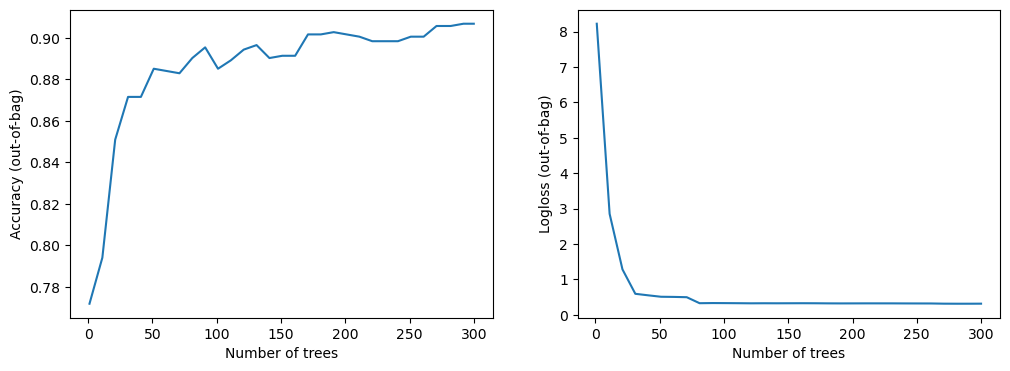


Train: 0.4859 Validation: 0.2855
##### Fold 6
Use /tmp/tmpovu3pu1i as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.269165. Found 555 examples.
Training model...
Model trained in 0:00:00.190579
Compiling model...


[INFO 23-07-22 08:03:13.3989 UTC kernel.cc:1242] Loading model from path /tmp/tmpovu3pu1i/model/ with prefix 8d3acce41a5648d6
[INFO 23-07-22 08:03:13.4433 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11238 node(s), and 58 input feature(s).
[INFO 23-07-22 08:03:13.4434 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:03:13.4434 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 283ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3069


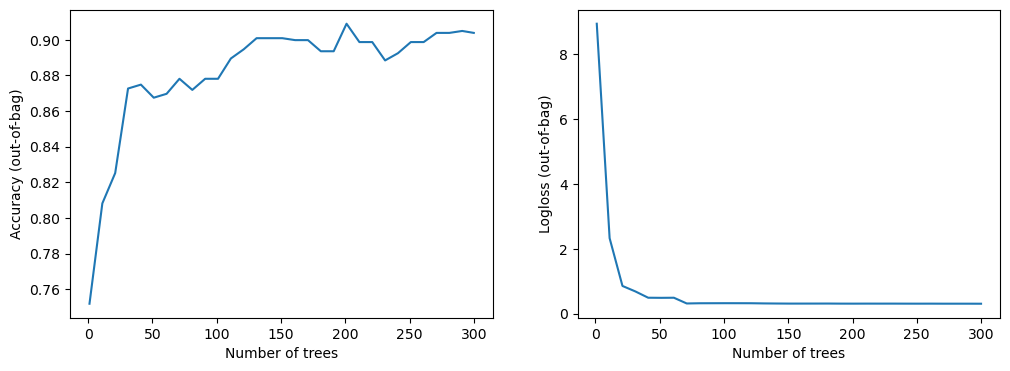


Train: 0.4704 Validation: 0.3069
##### Fold 7
Use /tmp/tmpudn_jvqn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.263256. Found 555 examples.
Training model...
Model trained in 0:00:00.221336
Compiling model...


[INFO 23-07-22 08:03:18.0359 UTC kernel.cc:1242] Loading model from path /tmp/tmpudn_jvqn/model/ with prefix d2137a02f7dc440e
[INFO 23-07-22 08:03:18.0810 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11262 node(s), and 59 input feature(s).
[INFO 23-07-22 08:03:18.0810 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 266ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3602


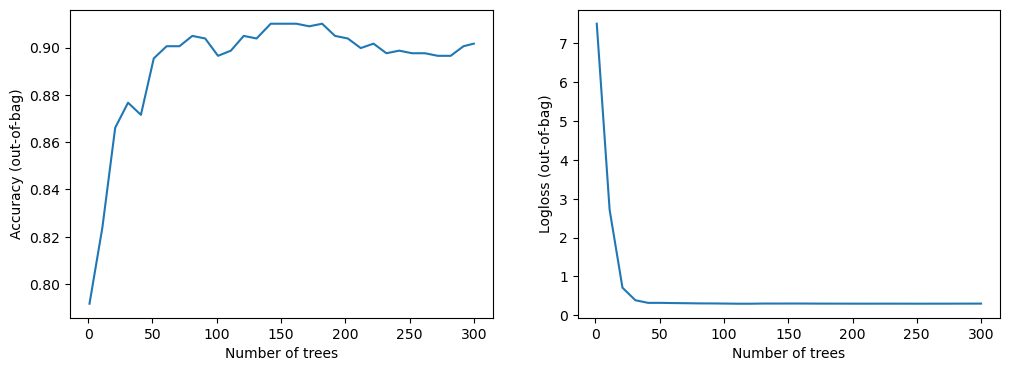


Train: 0.4883 Validation: 0.3602
##### Fold 8
Use /tmp/tmpaftoltqk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.265919. Found 556 examples.
Training model...
Model trained in 0:00:00.192106
Compiling model...


[INFO 23-07-22 08:03:22.6098 UTC kernel.cc:1242] Loading model from path /tmp/tmpaftoltqk/model/ with prefix 4c917bbf1f6c43c3
[INFO 23-07-22 08:03:22.6559 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11146 node(s), and 58 input feature(s).
[INFO 23-07-22 08:03:22.6563 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 267ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.3318


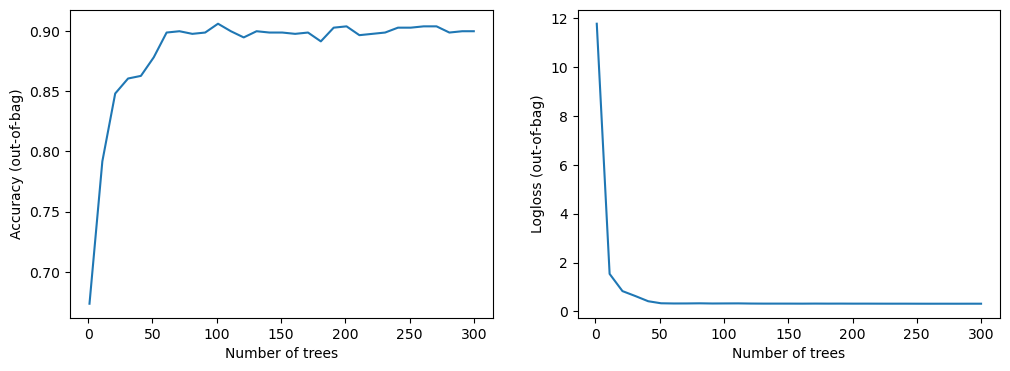


Train: 0.5488 Validation: 0.3318
##### Fold 9
Use /tmp/tmp29bltc5c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.241351. Found 556 examples.
Training model...
Model trained in 0:00:00.191692
Compiling model...


[INFO 23-07-22 08:03:27.1883 UTC kernel.cc:1242] Loading model from path /tmp/tmp29bltc5c/model/ with prefix d8598cdd1c8445bd
[INFO 23-07-22 08:03:27.2326 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11126 node(s), and 58 input feature(s).
[INFO 23-07-22 08:03:27.2326 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-22 08:03:27.2326 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 264ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3449


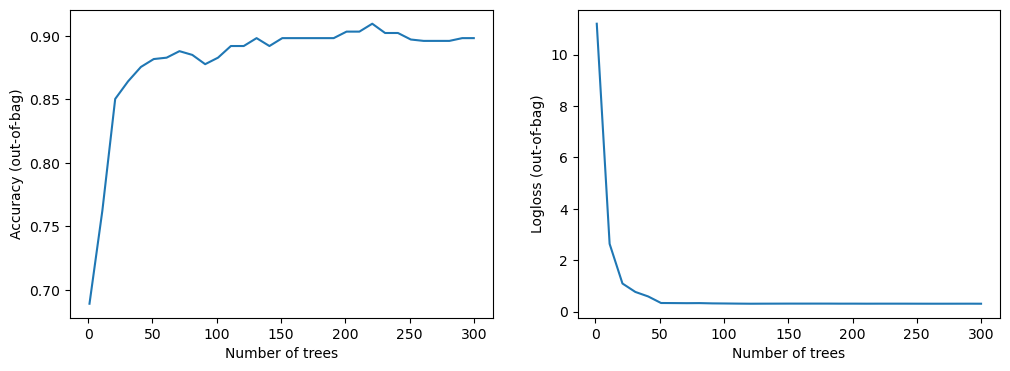


Train: 0.5168 Validation: 0.3449
##### Fold 10
Use /tmp/tmpie0cd_kp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.292127. Found 556 examples.
Training model...
Model trained in 0:00:00.192612
Compiling model...


[INFO 23-07-22 08:03:31.7731 UTC kernel.cc:1242] Loading model from path /tmp/tmpie0cd_kp/model/ with prefix d69b2a6631c449d4
[INFO 23-07-22 08:03:31.8175 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11154 node(s), and 58 input feature(s).
[INFO 23-07-22 08:03:31.8175 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 268ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.2687


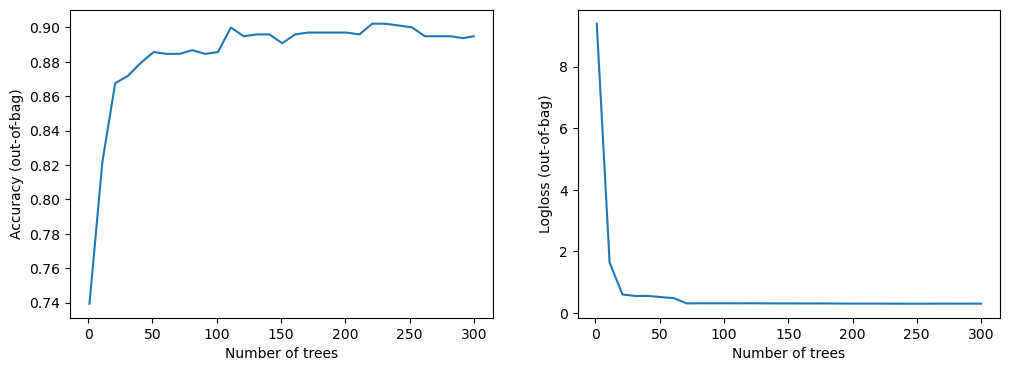


Train: 0.5330 Validation: 0.2687

Train mean: 0.4715 std: 0.1028

Validation mean: 0.3096 std: 0.0423


In [14]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=300),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# GradientBoostedTreesModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmphdohuxdb as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:03:35.5066 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:03:35.5067 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:03:35.5067 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.291690. Found 555 examples.
Training model...
Model trained in 0:00:02.080427
Compiling model...


[INFO 23-07-22 08:03:38.8680 UTC kernel.cc:1242] Loading model from path /tmp/tmphdohuxdb/model/ with prefix 709444b455ba4a5f
[INFO 23-07-22 08:03:38.8883 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-22 08:03:38.8883 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 267ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - balanced_log_loss: 0.0299


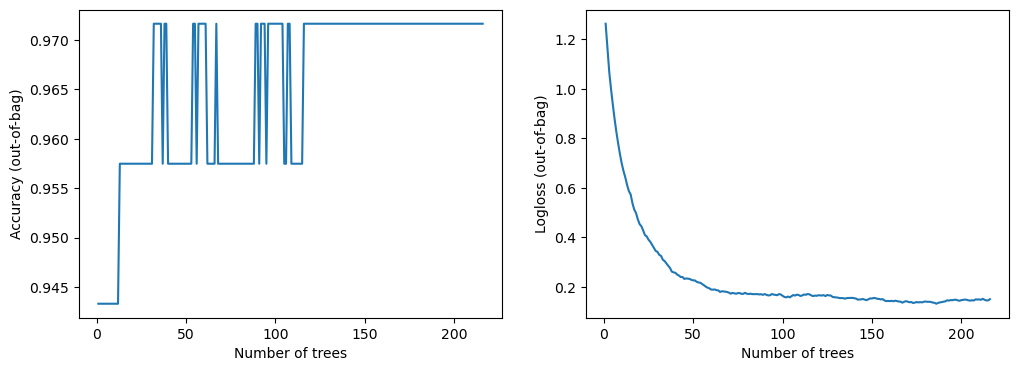


Train: 0.0060 Validation: 0.0299
##### Fold 2
Use /tmp/tmpchyo6kov as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:03:43.0945 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:03:43.0946 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:03:43.0946 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.509430. Found 555 examples.
Training model...
Model trained in 0:00:01.921317
Compiling model...


[INFO 23-07-22 08:03:46.5137 UTC kernel.cc:1242] Loading model from path /tmp/tmpchyo6kov/model/ with prefix fc858ee4e114495e
[INFO 23-07-22 08:03:46.5343 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 289ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9516 - balanced_log_loss: 0.1438


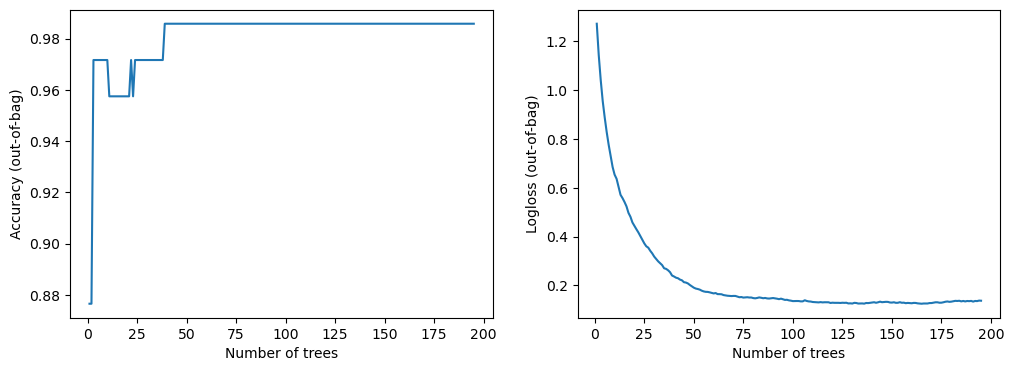


Train: 0.0360 Validation: 0.1438
##### Fold 3
Use /tmp/tmp_e9cpfoh as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:03:52.3451 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:03:52.3451 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:03:52.3451 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.396786. Found 555 examples.
Training model...
Model trained in 0:00:02.433552
Compiling model...


[INFO 23-07-22 08:03:56.1634 UTC kernel.cc:1242] Loading model from path /tmp/tmp_e9cpfoh/model/ with prefix 33ed0e0fe9a244d0
[INFO 23-07-22 08:03:56.1879 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-22 08:03:56.1880 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 280ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.8838


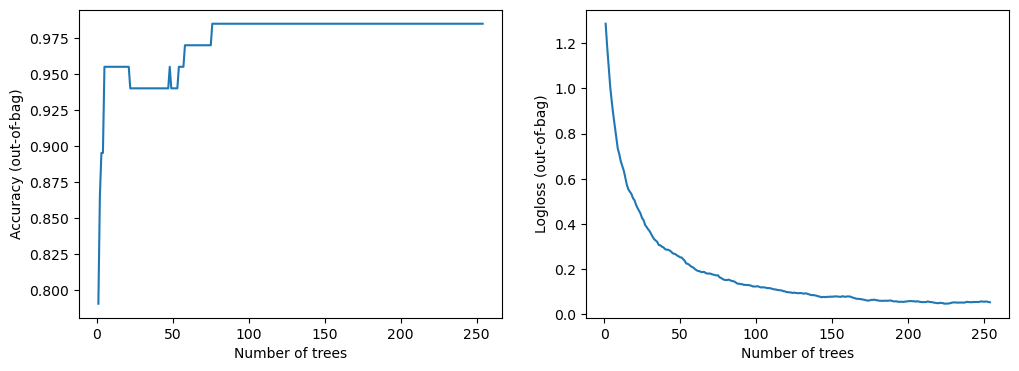


Train: 0.1457 Validation: 0.8838
##### Fold 4
Use /tmp/tmpmqyhz97l as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:04:01.3030 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:01.3030 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:01.3031 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.270057. Found 555 examples.
Training model...
Model trained in 0:00:02.530715
Compiling model...


[INFO 23-07-22 08:04:05.0864 UTC kernel.cc:1242] Loading model from path /tmp/tmpmqyhz97l/model/ with prefix 6bf9dab938114f68
[INFO 23-07-22 08:04:05.1121 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 278ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.3553


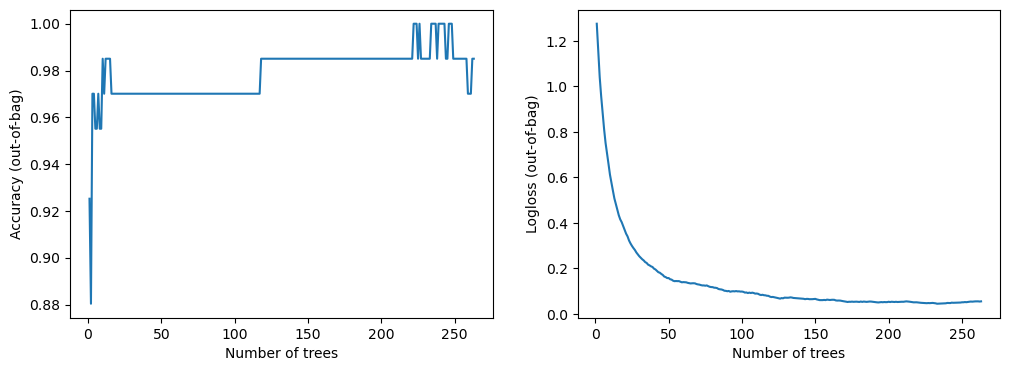


Train: 0.8856 Validation: 0.3553
##### Fold 5
Use /tmp/tmpbpx0cdv2 as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:04:08.2463 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:08.2464 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:08.2464 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.266247. Found 555 examples.
Training model...
Model trained in 0:00:02.649238
Compiling model...


[INFO 23-07-22 08:04:12.1435 UTC kernel.cc:1242] Loading model from path /tmp/tmpbpx0cdv2/model/ with prefix e31f250a279f43a8
[INFO 23-07-22 08:04:12.1711 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-22 08:04:12.1712 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 272ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.5371


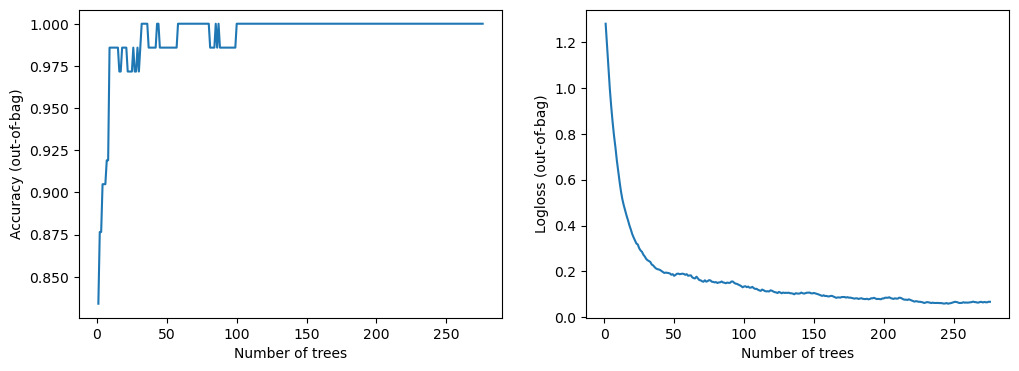


Train: 0.3576 Validation: 0.5371
##### Fold 6
Use /tmp/tmpo_qki816 as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:04:15.3138 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:15.3139 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:15.3139 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.273089. Found 555 examples.
Training model...
Model trained in 0:00:01.420310
Compiling model...


[INFO 23-07-22 08:04:18.0034 UTC kernel.cc:1242] Loading model from path /tmp/tmpo_qki816/model/ with prefix 8a05e5c3329a4df7
[INFO 23-07-22 08:04:18.0164 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 267ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2998


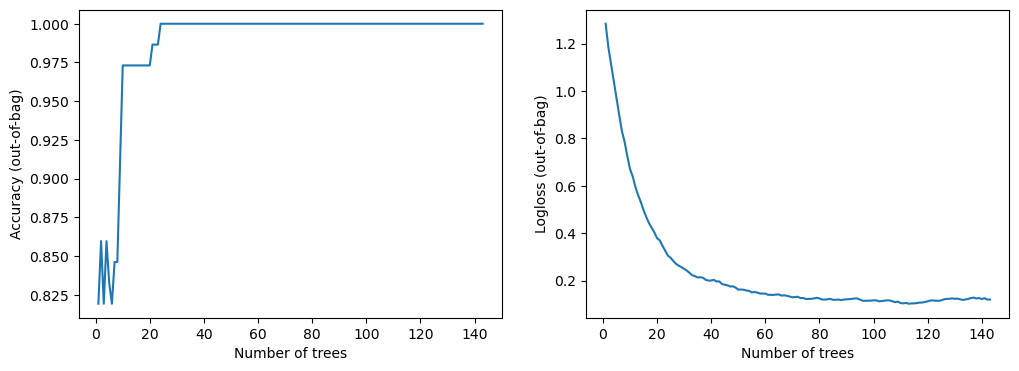


Train: 0.5467 Validation: 0.2998
##### Fold 7
Use /tmp/tmpb4ate_8c as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:04:21.5717 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:21.5718 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:21.5718 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.309182. Found 555 examples.
Training model...
Model trained in 0:00:00.673183
Compiling model...


[INFO 23-07-22 08:04:23.5586 UTC kernel.cc:1242] Loading model from path /tmp/tmpb4ate_8c/model/ with prefix 1a913b1c7d424458
[INFO 23-07-22 08:04:23.5633 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-22 08:04:23.5634 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 264ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3052


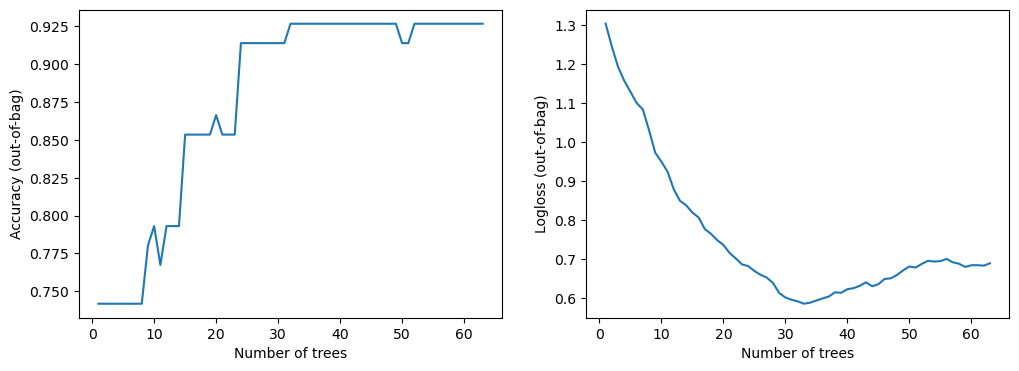


Train: 0.4053 Validation: 0.3052
##### Fold 8
Use /tmp/tmphb8zf0cr as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:04:26.7230 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:26.7230 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:26.7230 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.305903. Found 556 examples.
Training model...
Model trained in 0:00:00.675958
Compiling model...


[INFO 23-07-22 08:04:28.7102 UTC kernel.cc:1242] Loading model from path /tmp/tmphb8zf0cr/model/ with prefix 7da9632882524a48
[INFO 23-07-22 08:04:28.7151 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 264ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3190


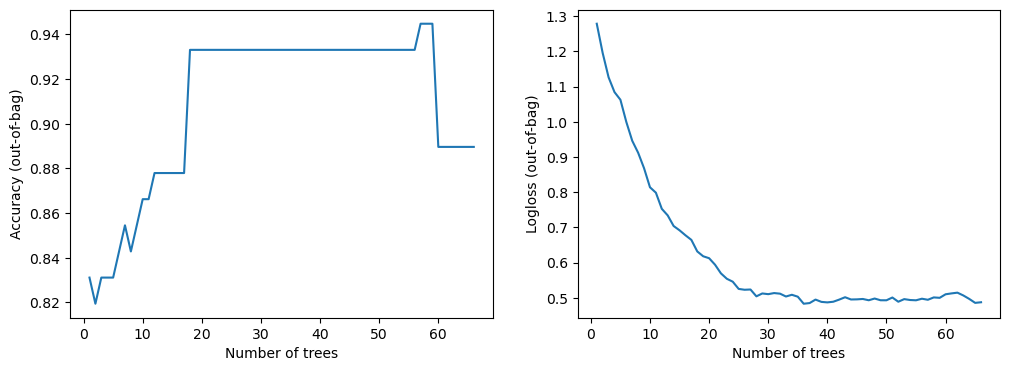


Train: 0.4007 Validation: 0.3190
##### Fold 9
Use /tmp/tmp_9ocg6_2 as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:04:33.0606 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:33.0607 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:33.0607 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.280226. Found 556 examples.
Training model...
Model trained in 0:00:01.000309
Compiling model...


[INFO 23-07-22 08:04:35.3408 UTC kernel.cc:1242] Loading model from path /tmp/tmp_9ocg6_2/model/ with prefix 74d44f2591fb4ead
[INFO 23-07-22 08:04:35.3511 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-22 08:04:35.3512 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 271ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.4456


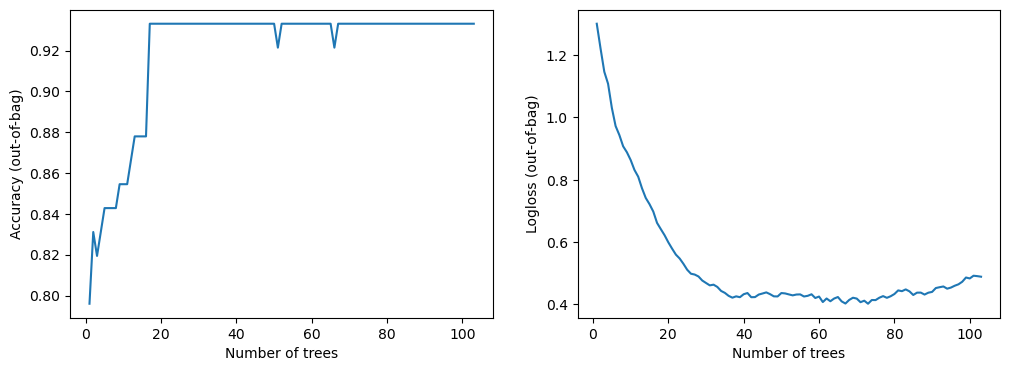


Train: 0.3539 Validation: 0.4456
##### Fold 10
Use /tmp/tmpyg_apoc6 as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:04:38.5059 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:38.5060 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:38.5060 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.296184. Found 556 examples.
Training model...
Model trained in 0:00:00.635183
Compiling model...


[INFO 23-07-22 08:04:40.4419 UTC kernel.cc:1242] Loading model from path /tmp/tmpyg_apoc6/model/ with prefix 452aab9d925f473b
[INFO 23-07-22 08:04:40.4465 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 268ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_log_loss: 0.2912


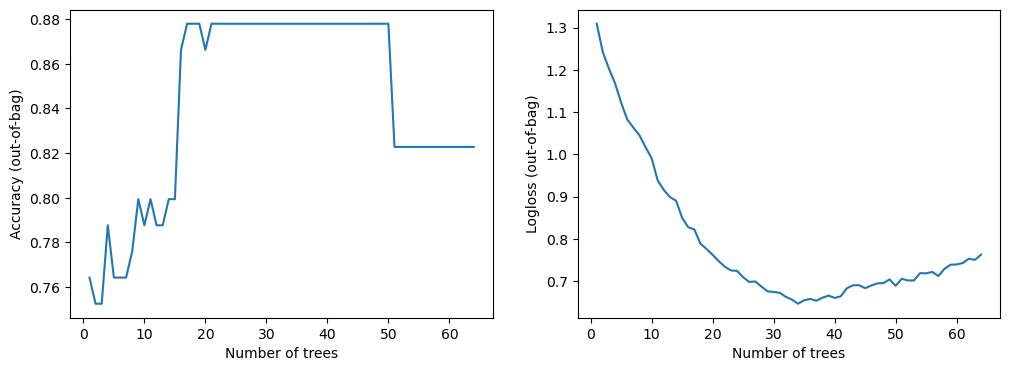


Train: 0.5554 Validation: 0.2912

Train mean: 0.3693 std: 0.2642

Validation mean: 0.3611 std: 0.2314


In [15]:
# GradientBoostedTreesModel

if not SUBMITION:

    features_slice = [i for i in features if len(i) > 2]

    train_summary_gbt_1, valid_summary_gbt_1, test_summary_gbt_1, model_gbt_1,metrics_gbt_1 = train_model(
        train=train_out,test=test_out, features=features_slice,                                             
        n_splits=10,                    
        model_obj=tfdf.keras.GradientBoostedTreesModel,            
        model_kwargs=dict(max_depth=5, num_trees=1000),                                                  
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, BalancedLogLoss()]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpjs1fyrbp as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:04:43.9491 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:43.9491 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:43.9492 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.282618. Found 555 examples.
Training model...
Model trained in 0:00:01.065816
Compiling model...


[INFO 23-07-22 08:04:46.2959 UTC kernel.cc:1242] Loading model from path /tmp/tmpjs1fyrbp/model/ with prefix a655d7fd689f4c2f
[INFO 23-07-22 08:04:46.3068 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-22 08:04:46.3069 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 275ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.1640


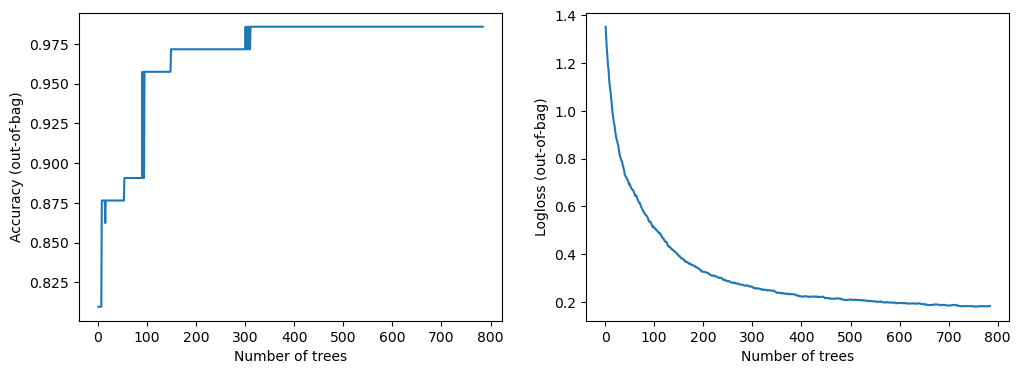


Train: 0.1127 Validation: 0.1640
##### Fold 2
Use /tmp/tmp941na3pq as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:04:49.5212 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:49.5212 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:49.5212 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.323220. Found 555 examples.
Training model...
Model trained in 0:00:00.658023
Compiling model...


[INFO 23-07-22 08:04:51.5041 UTC kernel.cc:1242] Loading model from path /tmp/tmp941na3pq/model/ with prefix f9703519543b4151
[INFO 23-07-22 08:04:51.5112 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 269ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.1576


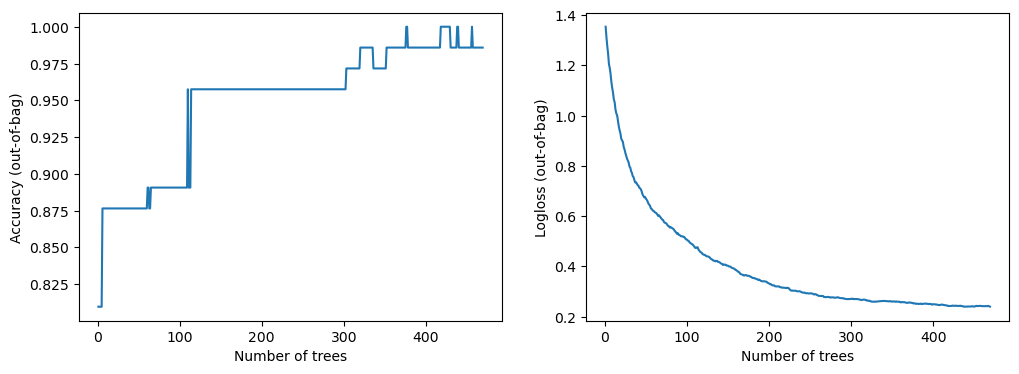


Train: 0.3058 Validation: 0.1576
##### Fold 3
Use /tmp/tmp272rp6t5 as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:04:54.6800 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:54.6801 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:04:54.6801 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:02.356054. Found 555 examples.
Training model...
Model trained in 0:00:00.784544
Compiling model...


[INFO 23-07-22 08:04:57.8221 UTC kernel.cc:1242] Loading model from path /tmp/tmp272rp6t5/model/ with prefix bc1485a99a5d47ba
[INFO 23-07-22 08:04:57.8298 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-22 08:04:57.8298 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 267ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.3384


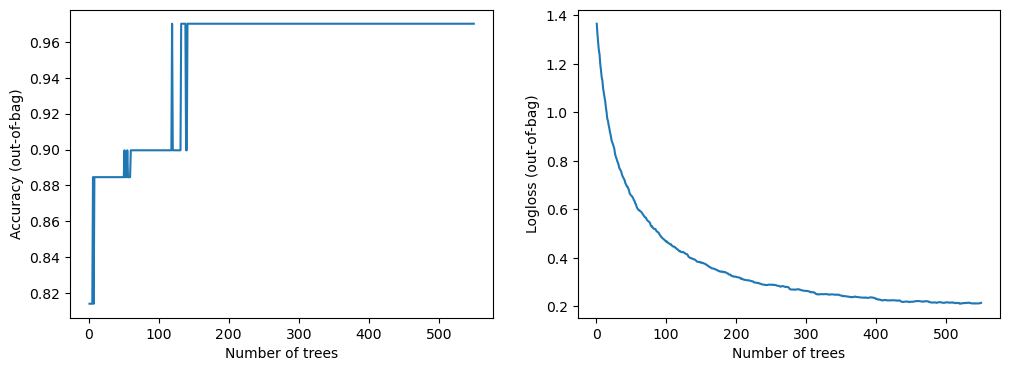


Train: 0.2765 Validation: 0.3384
##### Fold 4
Use /tmp/tmpwtdbvjz2 as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:05:01.9716 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:05:01.9717 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:05:01.9717 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.317590. Found 555 examples.
Training model...
Model trained in 0:00:00.655573
Compiling model...


[INFO 23-07-22 08:05:03.9469 UTC kernel.cc:1242] Loading model from path /tmp/tmpwtdbvjz2/model/ with prefix 9ed8e1f6ad094560
[INFO 23-07-22 08:05:03.9536 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 273ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.2671


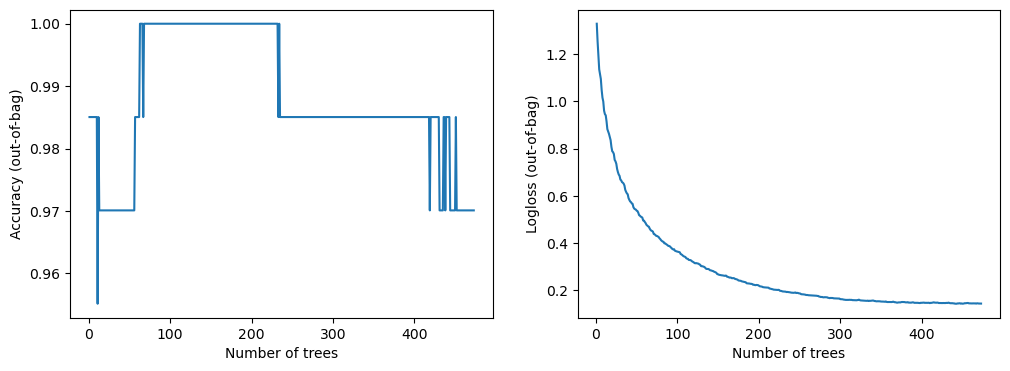


Train: 0.4713 Validation: 0.2671
##### Fold 5
Use /tmp/tmpragexqwv as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:05:08.1994 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:05:08.1995 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:05:08.1995 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.311115. Found 555 examples.
Training model...
Model trained in 0:00:01.017041
Compiling model...


[INFO 23-07-22 08:05:10.5283 UTC kernel.cc:1242] Loading model from path /tmp/tmpragexqwv/model/ with prefix a0ded17d866f4ef1
[INFO 23-07-22 08:05:10.5385 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-22 08:05:10.5386 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 300ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2613


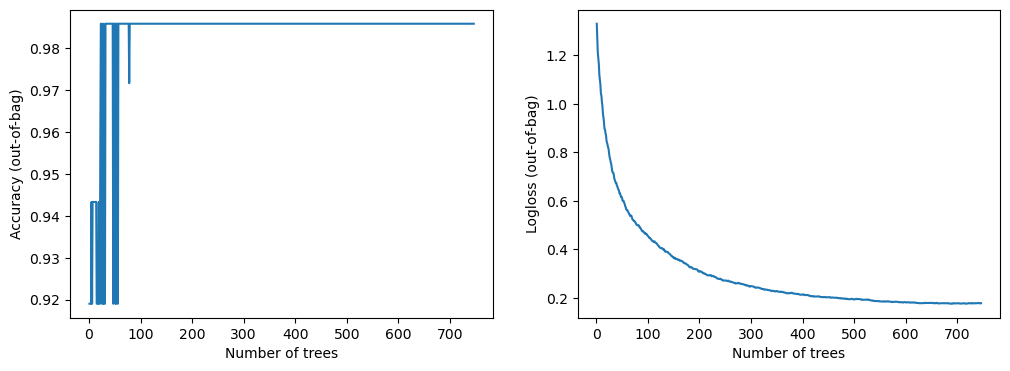


Train: 0.3730 Validation: 0.2613
##### Fold 6
Use /tmp/tmpwib0hb5q as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:05:13.6726 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:05:13.6726 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:05:13.6727 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.296663. Found 555 examples.
Training model...
Model trained in 0:00:01.184051
Compiling model...


[INFO 23-07-22 08:05:16.1513 UTC kernel.cc:1242] Loading model from path /tmp/tmpwib0hb5q/model/ with prefix 7eb6251e3753461d
[INFO 23-07-22 08:05:16.1627 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 270ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2744


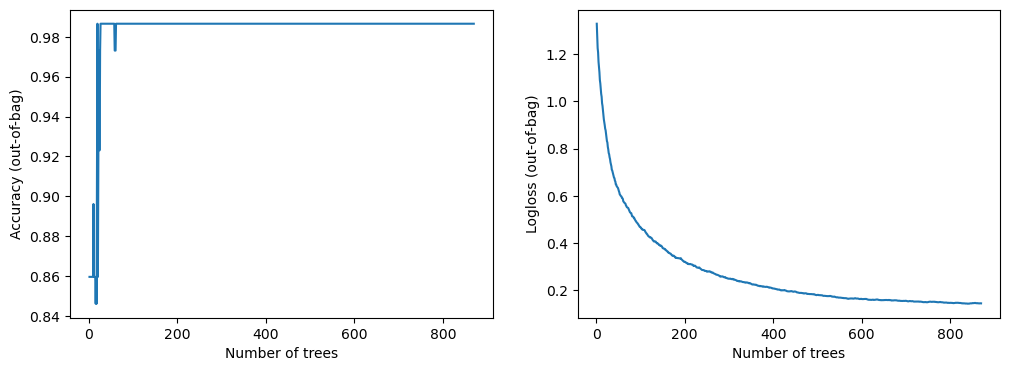


Train: 0.3571 Validation: 0.2744
##### Fold 7
Use /tmp/tmpec8po5jk as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:05:19.2243 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:05:19.2244 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:05:19.2244 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.384726. Found 555 examples.
Training model...
Model trained in 0:00:00.622262
Compiling model...


[INFO 23-07-22 08:05:21.2372 UTC kernel.cc:1242] Loading model from path /tmp/tmpec8po5jk/model/ with prefix 709e013c310848fc
[INFO 23-07-22 08:05:21.2428 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-22 08:05:21.2428 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 274ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.2420


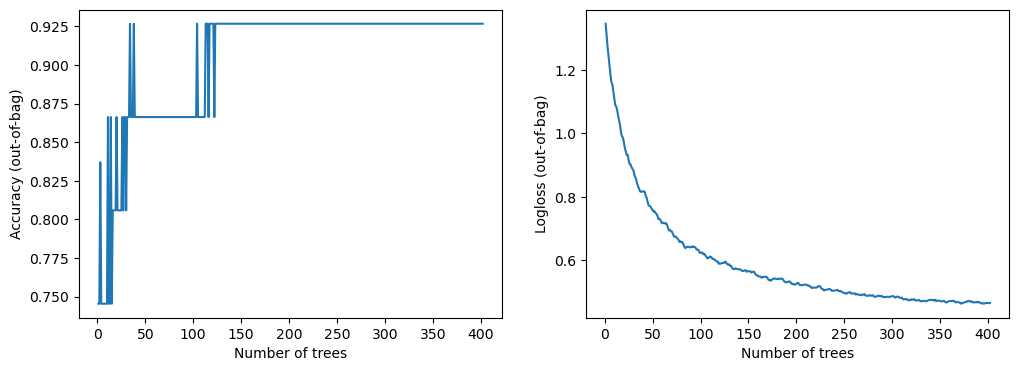


Train: 0.4262 Validation: 0.2420
##### Fold 8
Use /tmp/tmpie_h4oln as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:05:24.4118 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:05:24.4118 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:05:24.4118 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.300427. Found 556 examples.
Training model...
Model trained in 0:00:00.562979
Compiling model...


[INFO 23-07-22 08:05:26.2788 UTC kernel.cc:1242] Loading model from path /tmp/tmpie_h4oln/model/ with prefix a516cae57e5d40f3
[INFO 23-07-22 08:05:26.2844 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 270ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.2632


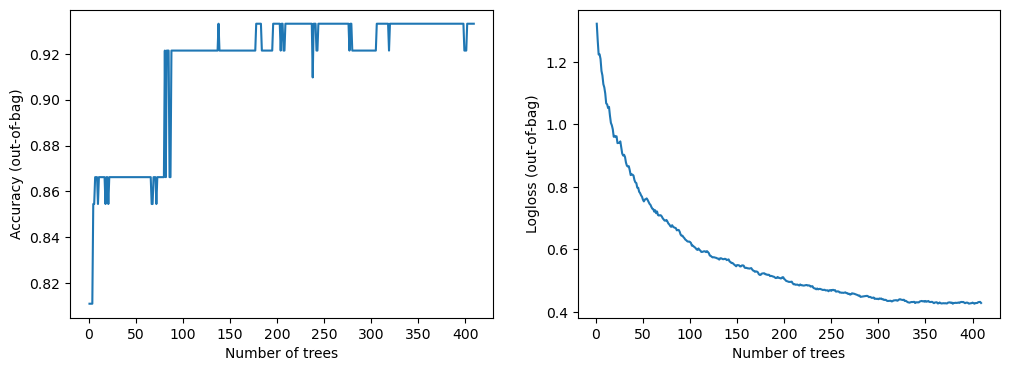


Train: 0.3848 Validation: 0.2632
##### Fold 9
Use /tmp/tmpkirmh283 as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:05:29.3652 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:05:29.3653 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:05:29.3653 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.304324. Found 556 examples.
Training model...
Model trained in 0:00:00.784482
Compiling model...


[INFO 23-07-22 08:05:31.4555 UTC kernel.cc:1242] Loading model from path /tmp/tmpkirmh283/model/ with prefix b710ed7396ef4eb2
[INFO 23-07-22 08:05:31.4631 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-22 08:05:31.4632 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 268ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8852 - balanced_log_loss: 0.3122


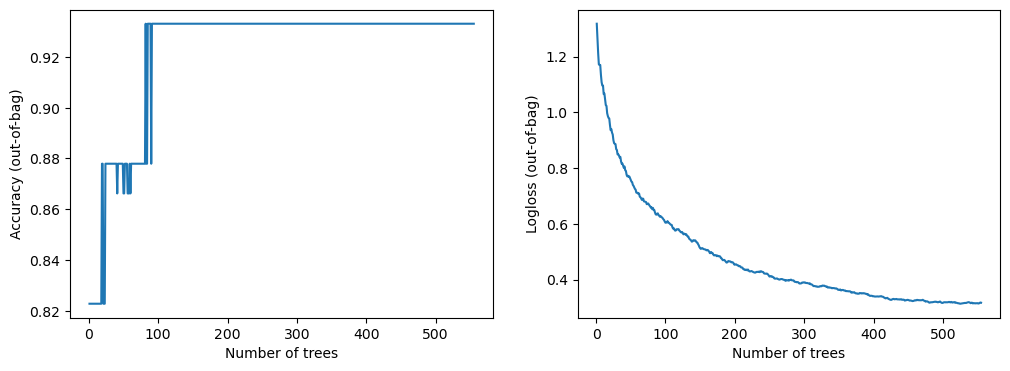


Train: 0.3803 Validation: 0.3122
##### Fold 10
Use /tmp/tmpdw4jxr98 as temporary training directory
Reading training dataset...


[WARNING 23-07-22 08:05:34.5187 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:05:34.5187 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-22 08:05:34.5187 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.303074. Found 556 examples.
Training model...
Model trained in 0:00:00.623888
Compiling model...


[INFO 23-07-22 08:05:36.4485 UTC kernel.cc:1242] Loading model from path /tmp/tmpdw4jxr98/model/ with prefix a77fb42ae3d64ff9
[INFO 23-07-22 08:05:36.4545 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 275ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.1399


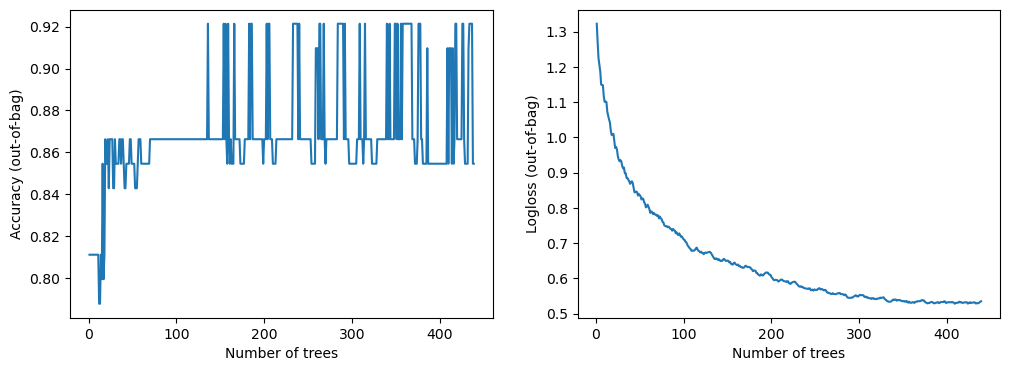


Train: 0.4631 Validation: 0.1399

Train mean: 0.3551 std: 0.1051

Validation mean: 0.2420 std: 0.0670


In [16]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

train_summary_gbt_2, valid_summary_gbt_2, test_summary_gbt_2, model_gbt_2,metrics_gbt_2 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.GradientBoostedTreesModel,            
    model_kwargs=dict(max_depth=2, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, BalancedLogLoss()]))

# TabPFN

In [17]:
def balanced_logloss_np(y_true: np.array, y_pred: np.array) -> float:
    
    # Correct Values
    min_val = 1e-15
    max_val = 0.999999999999999

    y_pred = np.minimum(y_pred, [max_val])
    y_pred = np.maximum(y_pred, [min_val])
    
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = np.reshape(np.log(y_pred_1),[-1,1])
    log_y_pred_0 = np.reshape(np.log(y_pred_0),[-1,1])

    y_1 = np.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -np.dot(y_1,log_y_pred_1)[0][0]/np.sum(y_1)
    logloss_0 = -np.dot(y_0,log_y_pred_0)[0][0]/np.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

def train_model_tabpfn_one(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class") -> (pd.DataFrame, dict, dict):

    # Create a dataframe of required size with zero values.
    test_summary = pd.DataFrame(data=np.full((len(test.index),1), np.nan),index=test.index)
    train_summary = pd.DataFrame(data=np.full((len(train.index),1), np.nan),index=train.index)
    # Create an empty dictionary to store the models trained for each fold.
    metrics = {}

    # Select only feature columns for training.
    train_df = train[features+[label]]

    # Define & Train the model and metrics
    model = TabPFNClassifier(N_ensemble_configurations=64)
    model.fit(train_df[features],train_df[label])

    # Make predictions
    p_train = model.predict_proba(train_df[features])[:,1]
    p_test = model.predict_proba(test[features])[:,1]

    # Predict value for validation/Submition data
    test_summary[0] = p_test.flatten() 
    train_summary[0] = p_train.flatten() 
    
    # Evaluate and store the metrics in respective dicts
    metrics['balanced_logloss'] = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
    print(f"\nTrain: {metrics['balanced_logloss']:.4f}")
    
            
    return train_summary, test_summary, model, metrics


def train_model_tabpfn_cv(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6) -> (pd.DataFrame, dict,  dict):

    # Create a various frames
    train_summary = pd.DataFrame(data=np.full((len(train.index),n_splits), np.nan), index=train.index) # For In-Sample Predictions of each Fold
    
    valid_summary = pd.DataFrame(data=np.full((len(train.index),1), np.nan), index=train.index) # For Out-of-Sample Prediction of each Fold
    
    test_summary = pd.DataFrame(data=np.full((len(test.index),n_splits), np.nan),index=test.index) # For Test (Sumbition) Predictions of each Fold's Model
    

    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Loop through each fold
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            train_ids = train_df.index.values
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # Define & Train the model
            model = TabPFNClassifier(N_ensemble_configurations=64)
            model.fit(train_df[features],train_df[label])

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict value for validation/Submition data
            p_train = model.predict_proba(train_df[features])[:,1]
            p_val = model.predict_proba(valid_df[features])[:,1]
            p_sub = model.predict_proba(test[features])[:,1]
            
            # Predict Values
            train_summary.loc[train_ids, i] = p_train
            valid_summary.loc[valid_ids, 0] = p_val
            test_summary[i] = p_sub

            # Evaluate and store the metrics in respective dicts
            train_metric = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
            val_metric = balanced_logloss_np(y_true=valid_df[label].values,y_pred=p_val)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
            
    return train_summary, valid_summary, test_summary, models,metrics

In [18]:
# TabPFN tabpfn_
if not SUBMITION:
    features_slice = [i for i in features if len(i) > 2]
    train_summary_tabpfn_1, test_summary_tabpfn_1, model_tabpfn_1, metrics_tabpfn_1 = train_model_tabpfn_one(
        train=train_out,test=test_out, features=features_slice)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0515


In [19]:
# TabPFN tabpfn_
features_slice = [i for i in features if len(i) > 2]
train_summary_tabpfn_2, valid_summary_tabpfn_2, test_summary_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
    train=train_out,test=test_out, features=features_slice, n_splits=6)

##### Fold 1
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0559 Validation: 0.1706
##### Fold 2
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0553 Validation: 0.2929
##### Fold 3
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0538 Validation: 0.2968
##### Fold 4
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0448 Validation: 0.1985
##### Fold 5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0518 Validation: 0.4682
##### Fold 6
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0511 Validation: 0.1178

Train mean: 0.0521 std: 0.0040

Validation mean: 0.2575 std: 0.1247


# Ensemble CV

In [20]:
class EnsembleCV(object):
    def __init__(self):
        self.is_fitted = False
        self.weights = None
        return
    
    def fit(self, X: pd.DataFrame) -> None:
        self.weights = None
        return
    
    @staticmethod
    def predict(X: pd.DataFrame) -> pd.Series:
        # Take conservative estimate
        X_ = X.mean(axis=1) #.to_frame()
        # Fillna by 1
        X_ = X_.fillna(1)
        return X_

In [21]:
rf_ensemble = EnsembleCV()
gbt_ensemble = EnsembleCV()
tabpfn_ensemble = EnsembleCV()

test_rf_ensemble = rf_ensemble.predict(X=test_summary_rf_3)
test_gbt_ensemble = gbt_ensemble.predict(X=test_summary_gbt_2)
test_tabpfn_ensemble = tabpfn_ensemble.predict(X=test_summary_tabpfn_1)

In [22]:
train_out['Class_RF'] = rf_ensemble.predict(X=train_summary_rf_3)
test_out['Class_RF'] = rf_ensemble.predict(X=test_summary_rf_3)

print(pd.Series(metrics_rf_3['train']).mean())
print(pd.Series(metrics_rf_3['val']).mean())
print(balanced_logloss_np(y_true=train_out['Class'].values,y_pred=train_out['Class_RF'].values))

0.47150743901729586
0.30964104533195497
0.18806014000614082


In [23]:
train_out['Class_GBT'] = gbt_ensemble.predict(X=train_summary_gbt_2)
test_out['Class_GBT'] = gbt_ensemble.predict(X=test_summary_gbt_2)

print(pd.Series(metrics_gbt_2['train']).mean())
print(pd.Series(metrics_gbt_2['val']).mean())
print(balanced_logloss_np(y_true=train_out['Class'].values,y_pred=train_out['Class_GBT'].values))

0.35506851226091385
0.24200911670923234
0.12420191674133182


In [24]:
train_out['Class_TABPFN'] = tabpfn_ensemble.predict(X=train_summary_tabpfn_1)
test_out['Class_TABPFN'] = tabpfn_ensemble.predict(X=test_summary_tabpfn_1)

print(pd.Series(metrics_tabpfn_2['train']).mean())
print(pd.Series(metrics_tabpfn_2['val']).mean())
print(balanced_logloss_np(y_true=train_out['Class'].values,y_pred=train_out['Class_TABPFN'].values))

0.052103748874421374
0.25747682209169853
0.05152794888626287


# Ensemble Classes

I can for example use GBT

In [25]:
train_out[['Class_RF','Class_GBT','Class_TABPFN','Class']].corr()

,Class_RF,Class_GBT,Class_TABPFN,Class
Class_RF,1.000000,0.957243,0.918721,0.878138
Class_GBT,0.957243,1.000000,0.938542,0.898006
Class_TABPFN,0.918721,0.938542,1.000000,0.987482
Class,0.878138,0.898006,0.987482,1.000000


In [26]:
# GradientBoostedTreesModel
# Got Very Bas score up to 1.5 in LB
# train_summary_gbt_3, valid_summary_gbt_3, test_summary_gbt_3, model_gbt_3,metrics_gbt_3 = train_model(
#     train=train_out,test=test_out, features=['Class_RF','Class_GBT','Class_TABPFN'],                                             
#     n_splits=10,                    
#     model_obj=tfdf.keras.GradientBoostedTreesModel,            
#     model_kwargs=dict(max_depth=2, num_trees=1000),                                                  
#     model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, BalancedLogLoss()]))

In [27]:
RF_w = 2.5/10
GBT_w = 4.5/10
TabPFN_w = 3./10

print('RF weight: ', RF_w)
print('GBT weight: ', GBT_w)
print('TabPFN weight: ', TabPFN_w)

submition_total = test_out[['Class_RF','Class_GBT','Class_TABPFN']].copy()
submition_total.columns = ['RF','GBT','TabPFN']

submition_total['Ensemble'] = RF_w*submition_total['RF'] + GBT_w*submition_total['GBT'] + TabPFN_w*submition_total['TabPFN']

submition_total.head()

RF weight:  0.25
GBT weight:  0.45
TabPFN weight:  0.3


,RF,GBT,TabPFN,Ensemble
Id,,,,
00eed32682bb,0.369333,0.731629,0.662171,0.620218
010ebe33f668,0.369333,0.731629,0.662171,0.620218
02fa521e1838,0.369333,0.731629,0.662171,0.620218
040e15f562a2,0.369333,0.731629,0.662171,0.620218
046e85c7cc7f,0.369333,0.731629,0.662171,0.620218


# Submission

In [28]:
# submition_total
submition_total['class_1'] = submition_total['Ensemble']
submition_total['class_0'] = 1 - submition_total['class_1']
submition_total = submition_total[['class_0','class_1']].copy()
submition_total.to_csv('/kaggle/working/submission.csv', index=True)

In [29]:
submition_total.head()

,class_0,class_1
Id,,
00eed32682bb,0.379782,0.620218
010ebe33f668,0.379782,0.620218
02fa521e1838,0.379782,0.620218
040e15f562a2,0.379782,0.620218
046e85c7cc7f,0.379782,0.620218


In [30]:
submition_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 00eed32682bb to 046e85c7cc7f
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   class_0  5 non-null      float32
 1   class_1  5 non-null      float32
dtypes: float32(2)
memory usage: 80.0+ bytes
